#Arbitrated Dynamic Ensemble

In [1]:
#install libraries
!pip install --upgrade linear-tree

In [2]:
#import libraries
import pandas as pd
import numpy as np
from google.colab import drive
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab import drive
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import shap
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader
from joblib import Parallel, delayed, dump, load
import xgboost as xgb
import time
import yfinance as yf
import torch.nn.functional as F
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LinearRegression
from lineartree import LinearBoostRegressor
from sklearn.datasets import make_regression
from sklearn.linear_model import Ridge


#ignore warnings
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [3]:
drive.mount('/content/gdrive')

#import time series
datasets = {}
for name in ['sp500', 'eur_usd']:
    datasets[name] = pd.read_csv(f'/content/gdrive/MyDrive/università/Machine_learning/Project_code/Datasets/{name}_data.csv', index_col=0)
    datasets[name] = datasets[name]
    datasets[name].index.name = 'Date'
    datasets[name].index = pd.to_datetime(datasets[name].index)


Close_price = {}
Log_return = {}
test_residuals = {}
val_residuals = {}
SARIMA_fitted_values = {}
SARIMA_test_predictions = {}
residuals = {}

for name , dataset in datasets.items():

    #save Close price and Log Returns into a pd.Series
    Close_price[name] = dataset['Close'].copy().astype(float)
    # Log_return[name] = dataset['Log Return'].copy().astype(float)

    #drop columns not needed
    # dataset.drop(['Open', 'High', 'Low', 'Close', 'Log Return'], axis=1, inplace=True)
    dataset.drop(['Open', 'High', 'Low', 'Close'], axis=1, inplace=True)


    #import SARIMA residuals
    residuals[name] = pd.read_csv(f'/content/gdrive/MyDrive/università/Machine_learning/Project_code/ARIMA/{name}/SARIMA_residuals.csv', index_col=0, sep=",")
    residuals[name].index = pd.to_datetime(residuals[name].index)


    #val residuals
    val_residuals[name] = pd.read_csv(f'/content/gdrive/MyDrive/università/Machine_learning/Project_code/ARIMA/{name}/SARIMA_val_residuals.csv', index_col=0, sep=",")
    val_residuals[name].index = pd.to_datetime(val_residuals[name].index)

    #test residuals
    test_residuals[name] = pd.read_csv(f'/content/gdrive/MyDrive/università/Machine_learning/Project_code/ARIMA/{name}/SARIMA_test_residuals.csv', index_col=0, sep=",")
    test_residuals[name].index = pd.to_datetime(test_residuals[name].index)

    #import SARIMA fitted values (predictions on the training set)
    SARIMA_fitted_values[name] = pd.read_csv(f'/content/gdrive/MyDrive/università/Machine_learning/Project_code/ARIMA/{name}/SARIMA_fitted_values.csv', index_col=0)
    SARIMA_fitted_values[name].index = pd.to_datetime(SARIMA_fitted_values[name].index)

    #import SARIMA predictions on the test set
    SARIMA_test_predictions[name] = pd.read_csv(f'/content/gdrive/MyDrive/università/Machine_learning/Project_code/ARIMA/{name}/SARIMA_test_predictions.csv', index_col=0).squeeze() #to read as a pd.Series
    SARIMA_test_predictions[name].index = pd.to_datetime(SARIMA_test_predictions[name].index)

Mounted at /content/gdrive


##Helper functions to move data to the GPU

In [5]:
#define some helper classes
def get_device():
    if torch.cuda.is_available():
        device = 'cuda'
    else:
        device = 'cpu'

    return device

def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    elif isinstance(data, torch.Tensor):  # Only move tensors to the device
        return data.to(device, non_blocking=True)
    else:
        return data  # For non-tensor types (e.g., strings), return as is


class DeviceDataLoader (): #receive a dataloader and move to the correct device
  def __init__(self, dl, device):
    self.dl = dl
    self.device = device

  def __iter__(self):
    for batch in self.dl:
      yield to_device(batch, device)

  def __len__(self):
    return len(self.dl)


#get device
device = get_device()

##Get pre-trained models

###Neural network models

LSTM followed by CNN

In [6]:
#custom loss
class RMSELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()

    def forward(self, yhat, y):
        return torch.sqrt(self.mse(yhat, y))


#istance of the custom loss
rmse_loss = torch.nn.MSELoss().to(device) #the loss is computed off the mse loss, the function return the rmse for easier comprehension


class LSTM_CNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super().__init__() #initialize the parent class
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size

        self.lstm = nn.LSTM(input_size=input_size,
                            hidden_size=hidden_size,
                            num_layers=num_layers,
                            batch_first=True) #This argument specifies the input and output tensors are provided as (batch, seq, feature)
        self.cnn = nn.Sequential(
            nn.Conv1d(in_channels=hidden_size, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2),
            nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2),
            #flatten
            nn.Flatten(),
            nn.LazyLinear(out_features=256),
            nn.ReLU(),
            nn.Linear(in_features=256, out_features=num_classes)
        )

    def forward(self, x):
        out, _ = self.lstm(x)  #stateless LSTM each batch is using a different hidden/cell state (initialized to 0)
        out = out.permute(0, 2, 1)
        out = self.cnn(out)
        # out = out.squeeze(-1)
        # print(out)
        return out

    def training_step(self, batch):
        x, y = batch
        out = self(x) # This calls self.forward(x) through the __call__ method
        #loss = torch.sqrt(F.mse_loss(out, y)) incorrect way
        loss = rmse_loss(out, y)
        return loss

    def validation_step(self, batch):
        x, y = batch
        out = self(x)
        #loss = torch.sqrt(F.mse_loss(out, y))
        loss = rmse_loss(out, y)
        return {'val_loss': loss.detach()} #loss.detatch disable gradient computation

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        return {'val_loss': epoch_loss.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}".format(epoch, result['lrs'][-1], result['train_loss'], result['val_loss']))


#instance of the model
LSTM_CNN_model = {}

for name, dataset in datasets.items():

    num_classes = 1 # regression
    # input_size = 32  # Number of features per time step
    input_size = 1 #number of input features
    hidden_size = 512 #number of hidden layer in each cell, the more is better, but also will slow down the training
    num_layers = 1

    LSTM_CNN_model[name] = LSTM_CNN(num_classes= num_classes, input_size = input_size, hidden_size = hidden_size, num_layers = num_layers)
    LSTM_CNN_model[name].to(device) #move the istance to the device

CNN + LSTM parallel architecture

In [7]:
class ParallelCNN_LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super().__init__()
        self.cnn = nn.Sequential(
            nn.Conv1d(in_channels=input_size, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2),
            nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.LazyLinear(out_features=128), #linear layer that automatically infer the input size
            nn.ReLU()
        )
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.fc_lstm = nn.Linear(hidden_size, 128)
        self.fc = nn.Linear(128*2, num_classes)

    def forward(self, x):
        #cnn takes input of shape (batch_size, channels, seq_len)
        x_cnn = x.permute(0, 2, 1)
        out_cnn = self.cnn(x_cnn)
        # lstm takes input of shape (batch_size, seq_len, input_size)
        out_lstm, _ = self.lstm(x)
        out_lstm = self.fc_lstm(out_lstm[:, -1, :])
        out = torch.cat([out_cnn, out_lstm], dim=1)
        out = self.fc(out)
        return out

    def training_step(self, batch):
        x, y = batch
        out = self(x) # This calls self.forward(x) through the __call__ method
        #loss = torch.sqrt(F.mse_loss(out, y)) incorrect way
        loss = rmse_loss(out, y)
        return loss

    def validation_step(self, batch):
        x, y = batch
        out = self(x)
        #loss = torch.sqrt(F.mse_loss(out, y))
        loss = rmse_loss(out, y)
        return {'val_loss': loss.detach()} #loss.detatch disable gradient computation

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        return {'val_loss': epoch_loss.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}".format(epoch, result['lrs'][-1], result['train_loss'], result['val_loss']))


#instance of the model
parallelCNNLSTM_model = {}

for name, dataset in datasets.items():

    num_classes = 1 # regression
    # input_size = 32  # Number of features per time step
    input_size = 1 #number of input features
    hidden_size = 512 #number of hidden layer in each cell, the more is better, but also will slow down the training
    num_layers = 1

    parallelCNNLSTM_model[name] = ParallelCNN_LSTM(num_classes= num_classes, input_size = input_size, hidden_size = hidden_size, num_layers = num_layers)
    parallelCNNLSTM_model[name].to(device) #move the istance to the device

LSTM

In [8]:
#custom loss
class RMSELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()

    def forward(self, yhat, y):
        return torch.sqrt(self.mse(yhat, y))


#istance of the custom loss
rmse_loss = torch.nn.MSELoss().to(device) #the loss is computed off the mse loss, the function return the rmse for easier comprehension

class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size=512, num_layers=3, dropout=0.3):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.num_classes = num_classes

        # LSTM layers
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout
        )

        # Fully connected layers
        self.fc1 = nn.Linear(hidden_size, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, self.num_classes)

        # Activation and dropout
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x):
        # LSTM output
        lstm_out, _ = self.lstm(x)

        # Pass only the last output
        lstm_out = lstm_out[:, -1, :]

        # Fully connected layers with ReLU and Dropout
        x = self.relu(self.fc1(lstm_out))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)  # Final prediction
        return x

    def training_step(self, batch):
        x, y = batch
        out = self(x) # This calls self.forward(x) through the __call__ method
        #loss = torch.sqrt(F.mse_loss(out, y)) incorrect way
        loss = rmse_loss(out, y)
        return loss

    def validation_step(self, batch):
        x, y = batch
        out = self(x)
        #loss = torch.sqrt(F.mse_loss(out, y))
        loss = rmse_loss(out, y)
        return {'val_loss': loss.detach()} #loss.detatch disable gradient computation

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        return {'val_loss': epoch_loss.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}".format(epoch, result['lrs'][-1], result['train_loss'], result['val_loss']))


#instance of the model
LSTM_model = {}

for name, dataset in datasets.items():

    num_classes = 1 # regression
    # input_size = 32  # Number of features per time step
    input_size = 1 #number of input features
    hidden_size = 512 #number of hidden layer in each cell, the more is better, but also will slow down the training
    num_layers = 3

    LSTM_model[name] = LSTM(num_classes= num_classes, input_size = input_size, hidden_size = hidden_size, num_layers = num_layers)
    LSTM_model[name].to(device) #move the istance to the device

CNN model

In [9]:
class CNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super().__init__()
        self.cnn = nn.Sequential(
            nn.Conv1d(in_channels=input_size, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2),
            nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.LazyLinear(out_features=128), #linear layer that automatically infer the input size
            nn.ReLU()
        )
        self.fc = nn.Linear(128, num_classes)

    def forward(self, x):
        #cnn takes input of shape (batch_size, channels, seq_len)
        x_cnn = x.permute(0, 2, 1)
        out_cnn = self.cnn(x_cnn)
        out = self.fc(out_cnn)
        return out

    def training_step(self, batch):
        x, y = batch
        out = self(x) # This calls self.forward(x) through the __call__ method
        #loss = torch.sqrt(F.mse_loss(out, y)) incorrect way
        loss = rmse_loss(out, y)
        return loss

    def validation_step(self, batch):
        x, y = batch
        out = self(x)
        #loss = torch.sqrt(F.mse_loss(out, y))
        loss = rmse_loss(out, y)
        return {'val_loss': loss.detach()} #loss.detatch disable gradient computation

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        return {'val_loss': epoch_loss.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}".format(epoch, result['lrs'][-1], result['train_loss'], result['val_loss']))


#instance of the model
CNN_model = {}

for name, dataset in datasets.items():

    num_classes = 1 # regression
    # input_size = 32  # Number of features per time step
    input_size = 1 #number of input features
    hidden_size = 512 #number of hidden layer in each cell, the more is better, but also will slow down the training
    num_layers = 1

    CNN_model[name] = CNN(num_classes= num_classes, input_size = input_size, hidden_size = hidden_size, num_layers = num_layers)
    CNN_model[name].to(device) #move the istance to the device

###Load models


In [10]:
# from inspect import modulesbyfile
drive.mount("/content/gdrive")

Linear_booster_model = {}
#import trained models
model_names = ["Linear_booster.joblib", "CNN", "LSTM", "LSTM_CNN", "ParallelCNN_LSTM"]
model_istances = ["Linear_booster_model", CNN_model, LSTM_model, LSTM_CNN_model, parallelCNNLSTM_model]


for name, _ in datasets.items():
    for i, model in enumerate(model_names):
        if model == "Linear_booster.joblib":
            model_path = f'/content/gdrive/MyDrive/università/Tesi/models/{name}/{model}'
            Linear_booster_model[name] = load(model_path)
        else:
            #load state dict
            model_path = f'/content/gdrive/MyDrive/università/Tesi/models/{name}/{model}_fine_tuned'
            model_istances[i][name].load_state_dict(torch.load(model_path, map_location=torch.device(device)))


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


##Data preprocessing


###Univariate sliding windows

In [ ]:
def sliding_windows(data, seq_length):
    X, y = [], []

    for i in range(len(data) - seq_length ):
        _x = data.iloc[i:i+seq_length]
        _y = data.iloc[i + seq_length]
        X.append(_x)
        y.append(_y)

    return np.array(X), np.array(y)


train_data = {}
val_data = {}
test_data = {}
train_val_data = {}
scaler = {}

train_data_scaled = {}
val_data_scaled = {}
test_data_scaled = {}
train_val_data_scaled = {}

X_train = {}
X_val = {}
X_test = {}
X_train_val = {}
y_train = {}
y_val = {}
y_test = {}
y_train_val = {}

X_train_flatten = {}
X_val_flatten = {}
X_test_flatten = {}
X_train_val_flatten = {}

for name, dataset in datasets.items():

    #univariate sliding window
    train_data[name] = val_residuals[name].loc[:'2020']
    train_data[name].index = pd.to_datetime(val_residuals[name].loc[:'2020'].index)

    val_data[name] = val_residuals[name].loc['2021':]
    val_data[name].index = pd.to_datetime(val_residuals[name].loc['2021':].index)

    test_data[name] = test_residuals[name]
    test_data[name].index = pd.to_datetime(test_residuals[name].index)

    train_val_data[name] = val_residuals[name]
    train_val_data[name].index = pd.to_datetime(val_residuals[name].index)


    #scale the data
    if name == "sp500":
        scaler[name] = MinMaxScaler(feature_range=(-1, 1)) #initilise scaler
        # scaler = MinMaxScaler(feature_range=(-1, 1)) #initilise scaler
        # scaler = StandardScaler()


    elif name == "eur_usd":
        scaler[name] = MinMaxScaler(feature_range=(-1, 1))
        # scaler[name] = MinMaxScaler(feature_range=(-1, 1))
        # scaler[name] = StandardScaler()


    train_data_scaled[name] = pd.DataFrame(scaler[name].fit_transform(train_data[name].values.reshape(-1, 1)))
    val_data_scaled[name] = pd.DataFrame(scaler[name].transform(val_data[name].values.reshape(-1, 1)))
    train_val_data_scaled[name] = pd.DataFrame(scaler[name].fit_transform(train_val_data[name].values.reshape(-1, 1)))
    test_data_scaled[name] = pd.DataFrame(scaler[name].transform(test_data[name].values.reshape(-1, 1)))


    #sliding windows
    X_train[name], y_train[name]  = sliding_windows(train_data_scaled[name], 10)
    X_test[name] , y_test[name] = sliding_windows(test_data_scaled[name], 10)
    X_val[name], y_val[name] = sliding_windows(val_data_scaled[name], 10)
    X_train_val[name], y_train_val[name] = sliding_windows(train_val_data_scaled[name], 10)


    # Flatten the sliding windows
    X_train_flatten[name] = X_train[name].reshape(X_train[name].shape[0], -1)
    X_val_flatten[name] = X_val[name].reshape(X_val[name].shape[0], -1)
    X_train_val_flatten[name] = X_train_val[name].reshape(X_train_val[name].shape[0], -1)
    X_test_flatten[name] = X_test[name].reshape(X_test[name].shape[0], -1)


In [ ]:
#create a custom dataset
class Custom_df(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __getitem__(self, index): #this method allows to retrieve a specific sample from the dataset based on its index (the index is passed to this method)
        input = torch.tensor(np.array(self.x[index]), dtype=torch.float32) #convert np array into a tensor
        target = torch.tensor(np.array(self.y[index]), dtype=torch.float32)
        return input, target

    def __len__(self):
        return len(self.x)


train_df = {}
test_df = {}
val_df = {}
train_val_df = {}

train_loader = {}
test_loader = {}
val_loader = {}
train_val_loader = {}

for name, dataset in datasets.items():

    #istance of the custom dataset class
    train_df[name] = Custom_df(X_train[name], y_train[name])
    test_df[name] = Custom_df(X_test[name], y_test[name])
    val_df[name] = Custom_df(X_val[name], y_val[name])
    train_val_df[name] = Custom_df(X_train_val[name], y_train_val[name])


    #create dataloaders (to perform training/inference in batch)
    batch_size = 128
    num_workers = 2

    train_loader[name] = DataLoader(train_df[name], batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True, persistent_workers=True)
    test_loader[name] = DataLoader(test_df[name], batch_size=batch_size*2, shuffle=False, num_workers=num_workers, pin_memory=True, persistent_workers=True)
    val_loader[name] = DataLoader(val_df[name], batch_size=batch_size*2, shuffle=False, num_workers=num_workers, pin_memory=True, persistent_workers=True)
    train_val_loader[name] = DataLoader(train_val_df[name], batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True, persistent_workers=True)


    #get device
    device = get_device()


    #move to device
    train_loader[name] = DeviceDataLoader(train_loader[name], device)
    test_loader[name] = DeviceDataLoader(test_loader[name], device)
    val_loader[name] = DeviceDataLoader(val_loader[name], device)
    train_val_loader[name] = DeviceDataLoader(train_val_loader[name], device)

##Predict Residulas and compute Squared errors


In [ ]:
#helper function to make inference with batches
@torch.no_grad()
def inference(model, data_loader):
    model.eval()  # Set the model to evaluation mode
    predictions = []
    actuals = []

    for batch in data_loader:
        input, output = batch  # Unpack your batch into input and output
        outputs = model(input) # Perform the forward pass

        # Move outputs and actuals back to CPU and append to lists
        predictions.append(outputs.cpu())
        actuals.append(output.cpu())

    # Concatenate all predictions and actuals into single tensors
    predictions = torch.cat(predictions, dim=0)
    actuals = torch.cat(actuals, dim=0)

    return predictions, actuals

In [ ]:

model_istances = [Linear_booster_model, CNN_model, LSTM_model, LSTM_CNN_model, parallelCNNLSTM_model]
model_names = ["Linear_booster", "CNN", "LSTM", "LSTM_CNN", "ParallelCNN_LSTM"]

for name , _ in datasets.items():
    for model_istance, model_name in zip (model_istances, model_names):
        print(f"{model_name}: {model_istance[name]}")

        #train predictions
        if model_istance[name] == Linear_booster_model[name]:
            #train val predictions
            train_val_prediction = model_istance[name].predict(X_train_val_flatten[name])

            #test predictions
            test_prediction = model_istance[name].predict(X_test_flatten[name])


            #unscale predictions
            test_prediction = scaler[name].inverse_transform(test_prediction.reshape(-1, 1))
            train_val_prediction = scaler[name].inverse_transform(train_val_prediction.reshape(-1, 1))


            #convert to pd DataFrame
            train_val_prediction = pd.DataFrame(train_val_prediction)
            train_val_prediction.index = train_val_data[name].index[10:]

            test_prediction = pd.DataFrame(test_prediction)
            test_prediction.index = test_data[name].index[10:]


            #compute error
            train_val_actual = train_val_data[name][10:]
            test_actual = test_data[name][10:]
            se_train_errors = (train_val_actual.values - train_val_prediction.values) **2
            se_test_errors = (test_actual.values - test_prediction.values) **2
            ae_train_errors = np.abs(train_val_actual.values - train_val_prediction.values)
            ae_test_errors = np.abs(test_actual.values - test_prediction.values)


            #train predictions
            plt.figure(figsize=(12, 6))
            sns.lineplot(x= train_val_actual.index, y = train_val_actual.iloc[:,0], label="Train Data")
            sns.lineplot(x=train_val_prediction.index, y=train_val_prediction.iloc[:,0], label= f"{model_name} on Train data")
            plt.title(f'{model_name} predictions on Train + Val Data {name}')
            plt.xlabel('Date')
            plt.ylabel('Close price residuals')
            plt.xticks(rotation=45)  # Rotate x-axis labels
            plt.tight_layout() # Automatically adjusts the layout
            plt.legend()
            plt.show()


            #se errors
            plt.figure(figsize=(12, 6))
            sns.lineplot(x= train_val_data[name][10:].index, y = se_train_errors.squeeze(), label="squared error on train data ")
            plt.title(f'{model_name} squared errors on Train + Val set {name}')
            plt.xlabel('Date')
            plt.show()


            #ae errors
            plt.figure(figsize=(12, 6))
            sns.lineplot(x= train_val_data[name][10:].index, y = ae_train_errors.squeeze(), label="AE error on train data")
            plt.title(f'{model_name} AE errors on Train + Val set {name}')
            plt.xlabel('Date')
            plt.show()


            #test predictions
            plt.figure(figsize=(12, 6))
            sns.lineplot(x= test_actual.index, y = test_actual.iloc[:,0], label="Test Data")
            sns.lineplot(x=test_prediction.index, y=test_prediction.iloc[:,0], label="XGBoost Predictions on Test Data")
            plt.title(f'{model_name} predictions on Test Data {name}')
            plt.xlabel('Date')
            plt.ylabel('Close price residuals')
            plt.xticks(rotation=45)  # Rotate x-axis labels
            plt.tight_layout() # Automatically adjusts the layout
            plt.legend()
            plt.show()


            #se errors
            plt.figure(figsize=(12, 6))
            sns.lineplot(x= test_data[name][10:].index, y = se_test_errors.squeeze(), label="squared error on test data")
            plt.title(f'{model_name} squared errors on Test set {name}')
            plt.xlabel('Date')
            plt.show()


            #ae errors
            plt.figure(figsize=(12, 6))
            sns.lineplot(x= test_data[name][10:].index, y = ae_test_errors.squeeze(), label="AE error on test data")
            plt.title(f'{model_name} AE errors on Test set {name}')
            plt.xlabel('Date')
            plt.show()


            #save SE errors on train and test set
            se_train_errors = pd.DataFrame(se_train_errors)
            se_train_errors.index = train_val_data[name][10:].index
            se_test_errors = pd.DataFrame(se_test_errors)
            se_test_errors.index = test_data[name][10:].index
            se_train_errors.to_csv(f'se_train_errors_{model_name}_{name}.csv')
            se_test_errors.to_csv(f'se_test_errors_{model_name}_{name}.csv')


            #save AE errors
            ae_train_errors = pd.DataFrame(ae_train_errors)
            ae_train_errors.index = train_val_data[name][10:].index
            ae_test_errors = pd.DataFrame(ae_test_errors)
            ae_test_errors.index = test_data[name][10:].index
            ae_train_errors.to_csv(f'ae_train_errors_{model_name}_{name}.csv')
            ae_test_errors.to_csv(f'ae_test_errors_{model_name}_{name}.csv')

        else:
            train_val_prediction, train_actual = inference(model_istance[name], train_val_loader[name])
            test_prediction, test_actual = inference(model_istance[name], test_loader[name])

            train_val_prediction = np.array(train_val_prediction)
            train_val_actual = np.array(train_actual)
            test_prediction = np.array(test_prediction)
            test_actual = np.array(test_actual)

            ## Inverse Scale
            train_val_prediction = scaler[name].inverse_transform(train_val_prediction.reshape(-1, 1))
            train_val_actual = scaler[name].inverse_transform(train_val_actual.reshape(-1,1))

            test_prediction = scaler[name].inverse_transform(test_prediction)
            test_actual = scaler[name].inverse_transform(test_actual)


            #set index
            train_val_prediction = pd.DataFrame(train_val_prediction)
            train_val_prediction.index = train_val_data[name].iloc[10:].index
            train_val_actual = pd.DataFrame(train_val_actual)
            train_val_actual.index = train_val_data[name][10:].index

            test_prediction = pd.DataFrame(test_prediction)
            test_prediction.index = test_data[name][10:].index
            test_actual = pd.DataFrame(test_actual)
            test_actual.index = test_data[name].iloc[10:].index

            #compute error
            se_train_errors = (train_val_actual - train_val_prediction) **2
            se_test_errors = (test_actual - test_prediction) **2

            ae_train_errors = np.abs(train_val_actual - train_val_prediction)
            ae_test_errors = np.abs(test_actual - test_prediction)


            #train predictions
            plt.figure(figsize=(12, 6))
            sns.lineplot(x= train_val_data[name].index, y = train_val_data[name].iloc[:,0], label="Train Data")
            sns.lineplot(x=train_val_data[name][10:].index, y=train_val_prediction.iloc[:,0], label= f"{model_name} predictions on Train data {name}")
            plt.title(f'{model_name} predictions on Train + Val Data')
            plt.xlabel('Date')
            plt.ylabel('Close price residuals')
            plt.xticks(rotation=45)  # Rotate x-axis labels
            plt.tight_layout() # Automatically adjusts the layout
            plt.legend()
            plt.show()


            #se errors
            plt.figure(figsize=(12, 6))
            sns.lineplot(x= train_val_data[name][10:].index, y = se_train_errors.iloc[:,0], label="squared error on train data")
            plt.title(f'{model_name} squared errors on Train + Val set')
            plt.xlabel('Date')
            plt.ylabel('SE error')
            plt.show()


            #ae errors
            plt.figure(figsize=(12, 6))
            sns.lineplot(x= train_val_data[name][10:].index, y = ae_train_errors.iloc[:,0], label="AE error on train data")
            plt.title(f'{model_name} AE errors on Train set')
            plt.xlabel('Date')
            plt.ylabel('AE error')
            plt.show()


            #test predictions
            plt.figure(figsize=(12, 6))
            sns.lineplot(x= test_data[name][10:].index, y = test_actual.iloc[:,0], label="Test Data")
            sns.lineplot(x=test_data[name][10:].index, y=test_prediction.iloc[:,0], label=f"{model_name} predictions on Test Data")
            plt.title(f'{model_name} predictions on Test Data {name}')
            plt.xlabel('Date')
            plt.ylabel('Close price residuals')
            plt.xticks(rotation=45)  # Rotate x-axis labels
            plt.tight_layout() # Automatically adjusts the layout
            plt.legend()
            plt.show()


            #se errors
            plt.figure(figsize=(12, 6))
            sns.lineplot(x= test_data[name][10:].index, y = se_test_errors.iloc[:,0], label="squared error on test data")
            plt.title(f'{model_name} squared errors on Test {name}')
            plt.xlabel('Date')
            plt.ylabel('SE error')
            plt.show()


            #ae errors
            plt.figure(figsize=(12, 6))
            sns.lineplot(x= test_data[name][10:].index, y = ae_test_errors.iloc[:,0], label="AE error on test data")
            plt.title(f'{model_name} AE errors on Test {name}')
            plt.xlabel('Date')
            plt.ylabel('AE error')
            plt.show()





            #save SE errors on train and test set
            se_train_errors = pd.DataFrame(se_train_errors)
            se_train_errors.index = train_val_data[name][10:].index
            se_test_errors = pd.DataFrame(se_test_errors)
            se_test_errors.index = test_data[name][10:].index
            se_train_errors.to_csv(f'se_train_errors_{model_name}_{name}.csv')
            se_test_errors.to_csv(f'se_test_errors_{model_name}_{name}.csv')


            #save AE errors
            ae_train_errors = pd.DataFrame(ae_train_errors)
            ae_train_errors.index = train_val_data[name][10:].index
            ae_test_errors = pd.DataFrame(ae_test_errors)
            ae_test_errors.index = test_data[name][10:].index
            ae_train_errors.to_csv(f'ae_train_errors_{model_name}_{name}.csv')
            ae_test_errors.to_csv(f'ae_test_errors_{model_name}_{name}.csv')




Output hidden; open in https://colab.research.google.com to view.

##Predict error

###Training meta model

In [ ]:
#create sliding windows
def sliding_windows(data, seq_length):
    X, y = [], []

    for i in range(len(data) - seq_length ):
        _x = data.iloc[i:i+seq_length]
        _y = data.iloc[i + seq_length]
        X.append(_x)
        y.append(_y)

    return np.array(X), np.array(y)


#create a custom dataset
class Custom_df(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __getitem__(self, index): #this method allows to retrieve a specific sample from the dataset based on its index (the index is passed to this method)
        input = torch.tensor(np.array(self.x[index]), dtype=torch.float32) #convert np array into a tensor
        target = torch.tensor(np.array(self.y[index]), dtype=torch.float32)
        return input, target

    def __len__(self):
        return len(self.x)


@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']


def fit(epochs, lr, model, train_loader, val_loader, warmup_epochs, weight_decay=0, grad_clip=None, opt_func=torch.optim.Adam):
    torch.cuda.empty_cache() #clear the unused memory from the GPU
    history = []
    optimizer = opt_func(model.parameters(), lr, weight_decay= weight_decay) #updates the model weights according to the learnign rate

    # Warm-up scheduler (linear increase of the learning rate during warm-up)
    warmup_scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda epoch: (epoch + 1) / warmup_epochs if epoch < warmup_epochs else 1)

    #Annealing scheduler (decrease the lr after the warm-up)
    annealing_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                          patience=5, #defines how many epochs to wait for an improvement
                                                          factor =0.5 , #factor by which the learning rate will be reduced
                                                          min_lr=1e-7, #sets the minimum learning rate that the scheduler can reach
                                                          eps=1e-08) #small value added to the learning rate for numerical stability

    for epoch in range(epochs):
        model.train()
        train_losses =[]
        lrs = []

        for batch in train_loader:
        #training loop
            input, output = batch
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward() #compute gradients

            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip) #gradient clippping

            optimizer.step() #update weights
            optimizer.zero_grad() #reset gradients

        #update lr
        if epoch < warmup_epochs:
            warmup_scheduler.step()
            if epoch == 0:
                print("warmup phase")
        else:
            annealing_scheduler.step(result['val_loss'])
            if epoch == warmup_epochs:
                print("annealing phase")

        #track lr
        lrs.append(get_lr(optimizer))

        #validation loop
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result) #print results

    return history



model_names = ["Linear_booster", "CNN", "LSTM", "LSTM_CNN", "ParallelCNN_LSTM"]
for model_name in model_names:
    print(f"predicting {model_name} SE errors")
    se_train_val_errors = pd.read_csv(f'se_train_errors_{model_name}.csv', index_col=0)
    se_test_errors = pd.read_csv(f'ae_test_errors_{model_name}.csv', index_col=0)
    se_train_val_errors.index = pd.to_datetime(se_train_val_errors.index)
    se_test_errors.index = pd.to_datetime(se_test_errors.index)
    if model_name == "Linear_booster":
        se_val_errors = se_train_val_errors.loc[val_data[10:].index]
        se_train_errors = se_train_val_errors.loc[train_data[10:].index]
    else:
        se_train_val_errors = se_train_val_errors.iloc[val_data[10:].index]
        se_test_errors = se_test_errors.iloc[train_data[10:].index]

    # print(f"predicting {model_name} AE erros")
    # ae_train_val_errors = pd.read_csv(f'ae_train_errors_{model_name}.csv', index_col=0)
    # ae_test_errors = pd.read_csv(f'ae_test_errors_{model_name}.csv', index_col=0)
    # ae_train_val_errors.index = pd.to_datetime(ae_train_val_errors.index)
    # ae_test_errors.index = pd.to_datetime(ae_test_errors.index)
    # if model_name == "XGBoost_model":
    #     ae_val_errors = ae_train_val_errors.loc[val_data.index]
    #     ae_train_errors = ae_train_val_errors.loc[train_data.index]
    # else:
    #     ae_train_val_errors = ae_train_val_errors.iloc[val_data[10:].index]
    #     ae_test_errors = ae_test_errors.iloc[train_data[10:].index]


    #scale
    # scaler = StandardScaler()
    # scaler = MinMaxScaler(feature_range=(-1, 1)) #initilise scaler
    # train_data_scaled = pd.DataFrame(scaler.fit_transform(se_train_errors))
    # val_data_scaled = pd.DataFrame(scaler.transform(se_val_errors))
    # train_val_data_scaled = pd.DataFrame(scaler.fit_transform(se_train_val_errors))
    # test_data_scaled = pd.DataFrame(scaler.transform(se_test_errors))


    scaler = MinMaxScaler(feature_range=(-1, 1)) #initilise scaler
    train_data_scaled = pd.DataFrame(scaler.fit_transform(ae_train_errors))
    val_data_scaled = pd.DataFrame(scaler.transform(se_val_errors))
    train_val_data_scaled = pd.DataFrame(scaler.fit_transform(se_train_val_errors))
    test_data_scaled = pd.DataFrame(scaler.transform(ae_test_errors))


    #generate sliding windows
    X_train, y_train = sliding_windows(train_data_scaled, 5)
    X_val, y_val = sliding_windows(val_data_scaled, 5)
    X_train_val, y_train_val = sliding_windows(train_val_data_scaled, 5)
    X_test, y_test = sliding_windows(test_data_scaled, 5)


    #istance of the custom dataset class
    train_df = Custom_df(X_train, y_train)
    test_df = Custom_df(X_test, y_test)
    train_val_df = Custom_df(X_train_val, y_train_val)
    val_df = Custom_df(X_val, y_val)


    #create dataloaders (to perform training/inference in batch)
    batch_size = 128
    num_workers = 2

    train_loader = DataLoader(train_df, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True, persistent_workers=True)
    test_loader = DataLoader(test_df, batch_size=batch_size*2, shuffle=False, num_workers=num_workers, pin_memory=True, persistent_workers=True)
    train_val_loader = DataLoader(train_val_df, batch_size=batch_size*2, shuffle=False, num_workers=num_workers, pin_memory=True, persistent_workers=True)
    val_loader = DataLoader(val_df, batch_size=batch_size*2, shuffle=False, num_workers=num_workers, pin_memory=True, persistent_workers=True)


    #get device
    device = get_device()


    #move to device
    train_loader = DeviceDataLoader(train_loader, device)
    test_loader = DeviceDataLoader(test_loader, device)
    train_val_loader = DeviceDataLoader(train_val_loader, device)
    val_loader = DeviceDataLoader(val_loader, device)


    #istance of the meta model
    num_classes = 1 # regression
    # input_size = 32  # Number of features per time step
    input_size = 1 #number of input features
    hidden_size = 512 #number of hidden layer in each cell, the more is better, but also will slow down the training
    num_layers = 1

    meta_model = ParallelCNN_LSTM(num_classes= num_classes, input_size = input_size, hidden_size = hidden_size, num_layers = num_layers)
    meta_model.to(device) #move the istance to the device


    #train meta model
    history = [evaluate(meta_model, test_loader)]

    epochs = 200
    max_lr = 0.001
    grad_clip = None
    weight_decay = 1e-5
    opt_func = torch.optim.Adam
    warmup_epochs = 10

    start_time = time.time()
    history += fit(epochs, max_lr, meta_model, train_loader, val_loader, warmup_epochs, weight_decay, grad_clip, opt_func)
    end_time = time.time()
    print(f"Training time: {end_time - start_time} seconds")


    #batch inference
    test_prediction, test_actual = inference(meta_model, test_loader)

    ## Inverse Scale
    test_prediction = scaler.inverse_transform(test_prediction)
    test_actual = scaler.inverse_transform(test_actual)


    #predictions on the test_loader
    test_prediction = pd.DataFrame(test_prediction)
    test_prediction.index = test_data[5:].index
    test_actual = pd.DataFrame(test_actual)
    test_actual.index = test_data[5:].index


    #predictions on the train_val_loader
    train_predictions, actual_train = inference(meta_model, train_val_loader)

    ## Inverse Scale
    train_predictions = scaler.inverse_transform(train_predictions)
    actual_train = scaler.inverse_transform(actual_train)


    if model_name == "XGBoost_model":
        train_predictions = pd.DataFrame(train_predictions)
        train_predictions.index = train_val_data[5:].index
        actual_train = pd.DataFrame(actual_train)
        actual_train.index = train_val_data[5:].index

    else:
        train_predictions = pd.DataFrame(train_predictions)
        train_predictions.index = train_data[15:].index
        actual_train = pd.DataFrame(actual_train)
        actual_train.index = train_data[15:].index


    #visualize
    #predictions on the train set
    plt.figure(figsize=(12, 6))
    sns.lineplot(x=train_predictions.index, y = train_predictions[0], color = "green", label = "predictions")
    sns.lineplot(x=actual_train.index, y = actual_train[0], color = "red", label = "Train set")
    plt.suptitle('Predictions on the Train Set')
    plt.show()


    #predictions on the test set
    plt.figure(figsize=(12, 6))
    sns.lineplot(x=test_prediction.index, y = test_prediction[0], color = "green", label = "predictions")
    sns.lineplot(x=test_actual.index, y = test_actual[0], color = "red", label = "val set")
    plt.suptitle('Predictions on the Val Set')
    plt.show()


predicting Linear_booster SE errors


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


warmup phase
Epoch [0], last_lr: 0.00020, train_loss: 0.3080, val_loss: 5009.5645


KeyboardInterrupt: 

predicting Linear_booster SE errors


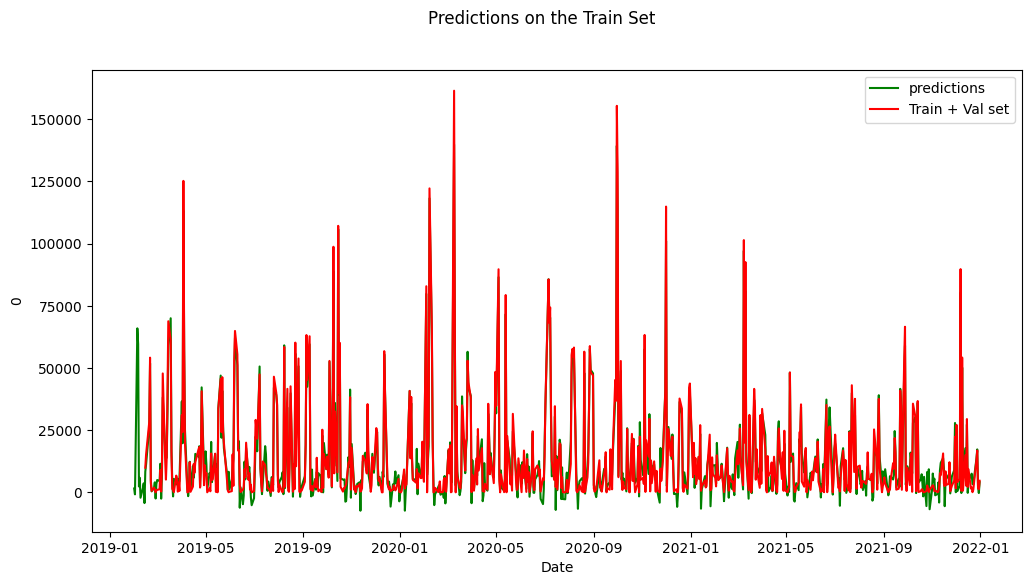

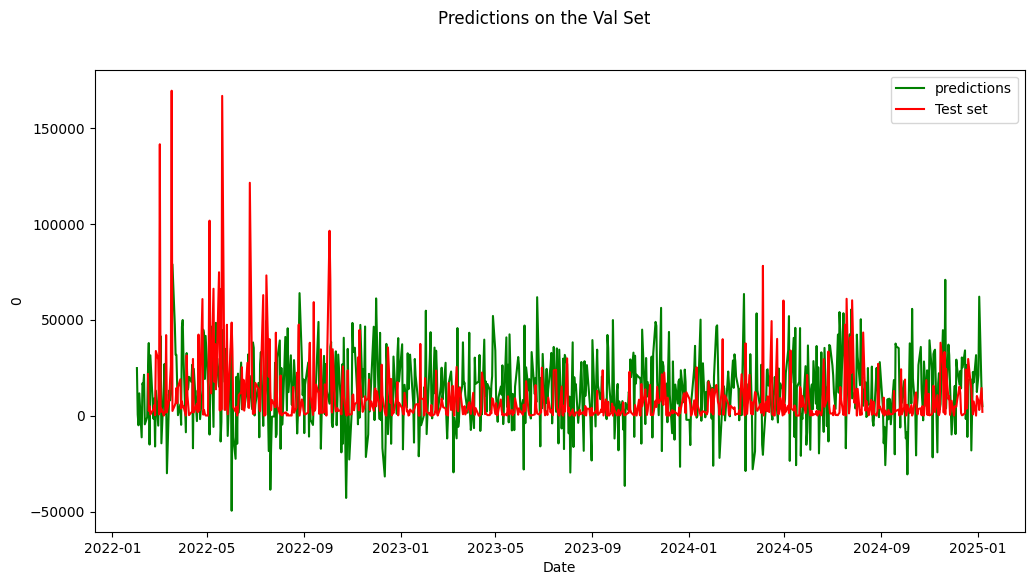

predicting CNN SE errors


IndexError: positional indexers are out-of-bounds

In [ ]:
#linear booster meta model

model_names = ["Linear_booster", "CNN", "LSTM", "LSTM_CNN", "ParallelCNN_LSTM"]

for name , _ in datasets.items():
    for model_name in model_names:
        print(f"predicting {model_name} SE errors")
        se_train_val_errors = pd.read_csv(f'se_train_errors_{model_name}_{name}.csv', index_col=0)
        se_test_errors = pd.read_csv(f'se_test_errors_{model_name}_{name}.csv', index_col=0)
        se_train_val_errors.index = pd.to_datetime(se_train_val_errors.index)
        se_test_errors.index = pd.to_datetime(se_test_errors.index)
        if model_name == "Linear_booster":
            se_val_errors = se_train_val_errors.loc[val_data[name][10:].index]
            se_train_errors = se_train_val_errors.loc[train_data[name][10:].index]
        else:
            se_train_val_errors = se_train_val_errors.iloc[val_data[name][10:].index]
            se_test_errors = se_test_errors.iloc[train_data[name][10:].index]

        # print(f"predicting {model_name} AE erros")
        # ae_train_val_errors = pd.read_csv(f'ae_train_errors_{model_name}.csv', index_col=0)
        # ae_test_errors = pd.read_csv(f'ae_test_errors_{model_name}.csv', index_col=0)
        # ae_train_val_errors.index = pd.to_datetime(ae_train_val_errors.index)
        # ae_test_errors.index = pd.to_datetime(ae_test_errors.index)
        # if model_name == "XGBoost_model":
        #     ae_val_errors = ae_train_val_errors.loc[val_data.index]
        #     ae_train_errors = ae_train_val_errors.loc[train_data.index]
        # else:
        #     ae_train_val_errors = ae_train_val_errors.iloc[val_data[10:].index]
        #     ae_test_errors = ae_test_errors.iloc[train_data[10:].index]


        #scale
        # scaler = StandardScaler()
        # scaler = MinMaxScaler(feature_range=(-1, 1)) #initilise scaler
        # train_data_scaled = pd.DataFrame(scaler.fit_transform(se_train_errors))
        # val_data_scaled = pd.DataFrame(scaler.transform(se_val_errors))
        # train_val_data_scaled = pd.DataFrame(scaler.fit_transform(se_train_val_errors))
        # test_data_scaled = pd.DataFrame(scaler.transform(se_test_errors))


        scaler = RobustScaler() #initilise scaler
        train_data_scaled = pd.DataFrame(scaler.fit_transform(se_train_errors), columns=se_train_errors.columns, index=se_train_errors.index)
        val_data_scaled = pd.DataFrame(scaler.transform(se_val_errors), columns=se_val_errors.columns, index=se_val_errors.index)
        train_val_data_scaled = pd.DataFrame(scaler.fit_transform(se_train_val_errors), columns=se_train_val_errors.columns, index=se_train_val_errors.index)
        test_data_scaled = pd.DataFrame(scaler.transform(se_test_errors), columns=se_test_errors.columns, index=se_test_errors.index)


        #generate sliding windows
        X_train, y_train = sliding_windows(train_data_scaled, 10)
        X_val, y_val = sliding_windows(val_data_scaled, 10)
        X_train_val, y_train_val = sliding_windows(train_val_data_scaled, 10)
        X_test, y_test = sliding_windows(test_data_scaled, 10)


        # Flatten the sliding windows
        X_train = X_train.reshape(X_train.shape[0], -1)
        X_val = X_val.reshape(X_val.shape[0], -1)
        X_train_val = X_train_val.reshape(X_train_val.shape[0], -1)
        X_test = X_test.reshape(X_test.shape[0], -1)


        #istance of the meta model
        best_params = {"n_estimators": 180,  "max_depth": 10,  "min_samples_split" : 10, "min_samples_leaf" : 0.1}


        #fit model
        ridge = Ridge(alpha=2)
        model = LinearBoostRegressor(base_estimator=ridge, **best_params)
        model.fit(X_train_val, y_train_val)


        #predictions
        test_predictions = model.predict(X_test)
        train_val_predictions = model.predict(X_train_val)


        #unscale predictions
        test_predictions = scaler.inverse_transform(test_predictions.reshape(-1, 1))
        train_val_predictions = scaler.inverse_transform(train_val_predictions.reshape(-1, 1))


        #convert to pd.DataFrame
        train_val_predictions = pd.DataFrame(train_val_predictions)
        train_val_predictions.index = train_val_data[name][20:].index

        test_predictions = pd.DataFrame(test_predictions)
        test_predictions.index = test_data[name][20:].index


        #visualize
        #predictions on the train set
        plt.figure(figsize=(12, 6))
        sns.lineplot(x=train_val_predictions.index, y = train_val_predictions[0], color = "green", label = "predictions")
        sns.lineplot(x=se_train_val_errors[20:].index, y = se_train_val_errors.iloc[20:,0], color = "red", label = "Train + Val set")
        plt.suptitle('Predictions on the Train Set')
        plt.show()


        #predictions on the test set
        plt.figure(figsize=(12, 6))
        sns.lineplot(x=test_predictions.index, y = test_predictions[0], color = "green", label = "predictions")
        sns.lineplot(x=se_test_errors[20:].index, y = se_test_errors.iloc[20:, 0], color = "red", label = "Test set")
        plt.suptitle('Predictions on the Val Set')
        plt.show()



###Transfer learning

Neural network meta model

In [ ]:
#helper function to make inference with batches
@torch.no_grad()
def inference(model, data_loader):
    model.eval()  # Set the model to evaluation mode
    predictions = []
    actuals = []

    for batch in data_loader:
        input, output = batch  # Unpack your batch into input and output
        outputs = model(input) # Perform the forward pass

        # Move outputs and actuals back to CPU and append to lists
        predictions.append(outputs.cpu())
        actuals.append(output.cpu())

    # Concatenate all predictions and actuals into single tensors
    predictions = torch.cat(predictions, dim=0)
    actuals = torch.cat(actuals, dim=0)

    return predictions, actuals


model_istances = [Linear_booster_model, CNN_model, LSTM_model, LSTM_CNN_model, parallelCNNLSTM_model]
model_names = ["Linear_booster", "CNN", "LSTM", "LSTM_CNN", "ParallelCNN_LSTM"]

for name, _ in datasets.items():
    print(f"predicting {name} SE errors")
    for model_name in model_names:
        print(f"predicting {model_name} SE errors")
        se_train_val_errors = pd.read_csv(f'se_train_errors_{model_name}_{name}.csv', index_col=0)
        se_test_errors = pd.read_csv(f'se_test_errors_{model_name}_{name}.csv', index_col=0)
        se_train_val_errors.index = pd.to_datetime(se_train_val_errors.index)
        se_test_errors.index = pd.to_datetime(se_test_errors.index)

        se_val_errors = se_train_val_errors.loc[val_data[name][10:].index]
        se_train_errors = se_train_val_errors.loc[train_data[name][10:].index]


        #scale
        # scaler = StandardScaler()
        # scaler = MinMaxScaler(feature_range=(-1, 1)) #initilise scaler
        # train_data_scaled = pd.DataFrame(scaler.fit_transform(se_train_errors))
        # val_data_scaled = pd.DataFrame(scaler.transform(se_val_errors))
        # train_val_data_scaled = pd.DataFrame(scaler.fit_transform(se_train_val_errors))
        # test_data_scaled = pd.DataFrame(scaler.transform(se_test_errors))


        # scaler = MinMaxScaler(feature_range=(-1, 1)) #initilise scaler
        scaler[name] = RobustScaler() #initilise scaler
        train_data_scaled = pd.DataFrame(scaler[name].fit_transform(se_train_errors))
        val_data_scaled = pd.DataFrame(scaler[name].transform(se_val_errors))
        train_val_data_scaled = pd.DataFrame(scaler[name].fit_transform(se_train_val_errors))
        test_data_scaled = pd.DataFrame(scaler[name].transform(se_test_errors))


        #generate sliding windows
        X_train, y_train = sliding_windows(train_data_scaled, 10)
        X_val, y_val = sliding_windows(val_data_scaled, 10)
        X_train_val, y_train_val = sliding_windows(train_val_data_scaled, 10)
        X_test, y_test = sliding_windows(test_data_scaled, 10)


        #istance of the custom dataset class
        train_df = Custom_df(X_train, y_train)
        test_df = Custom_df(X_test, y_test)
        train_val_df = Custom_df(X_train_val, y_train_val)
        val_df = Custom_df(X_val, y_val)


        #create dataloaders (to perform training/inference in batch)
        batch_size = 128
        num_workers = 2

        train_loader = DataLoader(train_df, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True, persistent_workers=True)
        test_loader = DataLoader(test_df, batch_size=batch_size*2, shuffle=False, num_workers=num_workers, pin_memory=True, persistent_workers=True)
        train_val_loader = DataLoader(train_val_df, batch_size=batch_size*2, shuffle=False, num_workers=num_workers, pin_memory=True, persistent_workers=True)
        val_loader = DataLoader(val_df, batch_size=batch_size*2, shuffle=False, num_workers=num_workers, pin_memory=True, persistent_workers=True)


        #get device
        device = get_device()


        #move to device
        train_loader = DeviceDataLoader(train_loader, device)
        test_loader = DeviceDataLoader(test_loader, device)
        train_val_loader = DeviceDataLoader(train_val_loader, device)
        val_loader = DeviceDataLoader(val_loader, device)


        #predictions on the test_loader
        prediction, actual = inference(parallelCNNLSTM_model[name], test_loader)

        ## Inverse Scale
        prediction = scaler[name].inverse_transform(prediction)
        actual = scaler[name].inverse_transform(actual)


        prediction = pd.DataFrame(prediction)
        prediction.index = test_data[name][20:].index
        actual = pd.DataFrame(actual)
        actual.index = test_data[name][20:].index


        #predictions on the train_val_loader
        train_val_predictions, actual_train_val = inference(parallelCNNLSTM_model[name], train_val_loader)

        ## Inverse Scale
        train_val_predictions = scaler[name].inverse_transform(train_val_predictions)
        actual_train_val = scaler[name].inverse_transform(actual_train_val)


        train_val_predictions = pd.DataFrame(train_val_predictions)
        train_val_predictions.index = train_val_data[name][20:].index
        actual_train_val = pd.DataFrame(actual_train_val)
        actual_train_val.index = train_val_data[name][20:].index


        #visualize
        #predictions on the train set
        plt.figure(figsize=(12, 6))
        sns.lineplot(x=train_val_predictions.index, y = train_val_predictions[0], color = "green", label = "predictions")
        sns.lineplot(x=actual_train_val.index, y = actual_train_val[0], color = "red", label = "Train set")
        plt.suptitle(f'{model_name} Squared Error predictions on the Train + Val Set')
        plt.show()


        #predictions on the test set
        plt.figure(figsize=(12, 6))
        sns.lineplot(x=prediction.index, y = prediction[0], color = "green", label = "predictions")
        sns.lineplot(x=actual.index, y = actual[0], color = "red", label = "Test set")
        plt.suptitle(f'{model_name} Squared Error predictions on the Test Set')
        plt.show()

        r2 = r2_score(actual, prediction)
        print(r2)


        # #close up
        # plt.figure(figsize=(12, 6))
        # sns.lineplot(x=prediction.loc["2024-09-01":].index, y = prediction[0].loc["2024-09-01":], color = "green", label = "predictions")
        # sns.lineplot(x=actual.loc["2024-09-01":].index, y = actual[0].loc["2024-09-01":], color = "red", label = "val set")
        # plt.suptitle(f'{model_name} Squared Error predictions on the Test Set')
        # plt.show()


        # #close up
        # plt.figure(figsize=(12, 6))
        # sns.lineplot(x=prediction.loc["2022-01-01":"2023-01-01"].index, y = prediction[0].loc["2022-01-01":"2023-01-01"], color = "green", label = "predictions")
        # sns.lineplot(x=actual.loc["2022-01-01":"2023-01-01"].index, y = actual[0].loc["2022-01-01":"2023-01-01"], color = "red", label = "val set")
        # plt.suptitle(f'{model_name} Squared Error predictions on the Test Set')
        # plt.show()


        #save ae test predictions
        # prediction.to_csv(f'ae_test_errors_predictions_{model_name}.csv')


Output hidden; open in https://colab.research.google.com to view.

Linear Booster meta model

In [ ]:
#linear booster meta model

model_names = ["Linear_booster", "CNN", "LSTM", "LSTM_CNN", "ParallelCNN_LSTM"]

#pre trained meta model
model_path = f'/content/gdrive/MyDrive/università/Tesi/models/meta_models/Linear_booster.joblib'
meta_model =  load(model_path)

for name, _ in datasets.items():
    print(f"predicting {name} SE errors")
    for model_name in model_names:
        print(f"predicting {model_name} SE errors")
        se_train_val_errors = pd.read_csv(f'se_train_errors_{model_name}_{name}.csv', index_col=0)
        se_test_errors = pd.read_csv(f'se_test_errors_{model_name}_{name}.csv', index_col=0)
        se_train_val_errors.index = pd.to_datetime(se_train_val_errors.index)
        se_test_errors.index = pd.to_datetime(se_test_errors.index)
        se_val_errors = se_train_val_errors.loc[val_data[name][10:].index]
        se_train_errors = se_train_val_errors.loc[train_data[name][10:].index]


        # print(f"predicting {model_name} AE erros")
        # ae_train_val_errors = pd.read_csv(f'ae_train_errors_{model_name}.csv', index_col=0)
        # ae_test_errors = pd.read_csv(f'ae_test_errors_{model_name}.csv', index_col=0)
        # ae_train_val_errors.index = pd.to_datetime(ae_train_val_errors.index)
        # ae_test_errors.index = pd.to_datetime(ae_test_errors.index)
        # if model_name == "XGBoost_model":
        #     ae_val_errors = ae_train_val_errors.loc[val_data.index]
        #     ae_train_errors = ae_train_val_errors.loc[train_data.index]
        # else:
        #     ae_train_val_errors = ae_train_val_errors.iloc[val_data[10:].index]
        #     ae_test_errors = ae_test_errors.iloc[train_data[10:].index]


        #scale
        # scaler = StandardScaler()
        # scaler = MinMaxScaler(feature_range=(-1, 1)) #initilise scaler
        # train_data_scaled = pd.DataFrame(scaler.fit_transform(se_train_errors))
        # val_data_scaled = pd.DataFrame(scaler.transform(se_val_errors))
        # train_val_data_scaled = pd.DataFrame(scaler.fit_transform(se_train_val_errors))
        # test_data_scaled = pd.DataFrame(scaler.transform(se_test_errors))


        scaler = RobustScaler() #initilise scaler
        train_data_scaled = pd.DataFrame(scaler.fit_transform(se_train_errors), columns=se_train_errors.columns, index=se_train_errors.index)
        val_data_scaled = pd.DataFrame(scaler.transform(se_val_errors), columns=se_val_errors.columns, index=se_val_errors.index)
        train_val_data_scaled = pd.DataFrame(scaler.fit_transform(se_train_val_errors), columns=se_train_val_errors.columns, index=se_train_val_errors.index)
        test_data_scaled = pd.DataFrame(scaler.transform(se_test_errors), columns=se_test_errors.columns, index=se_test_errors.index)


        #generate sliding windows
        X_train, y_train = sliding_windows(train_data_scaled, 10)
        X_val, y_val = sliding_windows(val_data_scaled, 10)
        X_train_val, y_train_val = sliding_windows(train_val_data_scaled, 10)
        X_test, y_test = sliding_windows(test_data_scaled, 10)


        # Flatten the sliding windows
        X_train = X_train.reshape(X_train.shape[0], -1)
        X_val = X_val.reshape(X_val.shape[0], -1)
        X_train_val = X_train_val.reshape(X_train_val.shape[0], -1)
        X_test = X_test.reshape(X_test.shape[0], -1)


        #predictions
        test_predictions = meta_model.predict(X_test)
        train_val_predictions = meta_model.predict(X_train_val)


        #unscale predictions
        test_predictions = scaler.inverse_transform(test_predictions.reshape(-1, 1))
        train_val_predictions = scaler.inverse_transform(train_val_predictions.reshape(-1, 1))


        #convert to pd.DataFrame
        train_val_predictions = pd.DataFrame(train_val_predictions)
        train_val_predictions.index = train_val_data[name][20:].index

        test_predictions = pd.DataFrame(test_predictions)
        test_predictions.index = test_data[name][20:].index


        #visualize
        #predictions on the train + val set
        plt.figure(figsize=(12, 6))
        sns.lineplot(x=train_val_predictions.index, y = train_val_predictions[0], color = "green", label = "predictions")
        sns.lineplot(x=se_train_val_errors[20:].index, y = se_train_val_errors.iloc[20:,0], color = "red", label = "Train + Val set")
        plt.suptitle(f'{model_name} Squared Error predictions on the Train + Val Set')
        plt.show()


        #predictions on the test set
        plt.figure(figsize=(12, 6))
        sns.lineplot(x=test_predictions.index, y = test_predictions[0], color = "green", label = "predictions")
        sns.lineplot(x=se_test_errors[20:].index, y = se_test_errors.iloc[20:, 0], color = "red", label = "Test set")
        plt.suptitle(f'{model_name} Squared Error predictions on the Test Set')
        plt.show()


Output hidden; open in https://colab.research.google.com to view.

##Combine predictions

In [ ]:
model_istances = [Linear_booster_model, CNN_model, LSTM_model, LSTM_CNN_model, parallelCNNLSTM_model]
model_names = ["Linear_booster", "CNN", "LSTM", "LSTM_CNN", "ParallelCNN_LSTM"]

#create a dataframe containing all the errors predicted on the test set
# error_df = pd.DataFrame()
# for model_istance, model_name in zip (model_istances, model_names):
#     prediction = pd.read_csv(f'ae_test_errors_predictions_{model_name}.csv', index_col=0)
#     prediction.index = pd.to_datetime(prediction.index)
#     error_df[model_name] = prediction.squeeze()


error_df = []
for model_name in model_names:
    prediction = pd.read_csv(f'ae_test_errors_predictions_{model_name}.csv', index_col=0)
    if model_name == "XGBoost_model":
        prediction = prediction[10:]
    # prediction.index = pd.to_datetime(prediction.index)
    prediction = torch.tensor(prediction.squeeze().values, dtype=torch.float32)
    error_df.append(prediction)
error_df = torch.stack(error_df, dim=1)



print(error_df)
# print(error_df.shape)

#compute weights using softmax function
# error_df = torch.tensor(error_df.values, dtype=torch.float32) # Convert DataFrame to PyTorch tensor
scaled_errors = (error_df - error_df.min(dim=1, keepdim=True)[0] ) / (error_df.max(dim=1, keepdim=True)[0] - error_df.min(dim=1, keepdim=True)[0]) # Normalize the tensor

mean_errors = error_df.mean(dim=1, keepdim=True)
std_errors = error_df.std(dim=1, keepdim=True)
normalized_errors = (error_df - mean_errors) / std_errors


print(scaled_errors)
weights_df = F.softmax(-normalized_errors, dim=1)
weights_df


#convert tensor to numpy array
# if (device == "cuda"):
#     weights_df = weights_df.cpu()
# weights_df = weights_df.numpy()

# # Create pandas dataframe
# weights_df = pd.DataFrame(weights_df, index=test_data[20:].index, columns=[f"{model_name}_weight" for model_name in model_names])
# weights_df

tensor([[19591.2188, 25399.3945, 13797.2451,  7765.7227, 11920.2646],
        [ 7042.4800, 27512.4844,  6036.6069,  5976.3574,  7284.3418],
        [12580.0781, 18498.1816,  5258.9780,  8020.2935,  6231.5273],
        ...,
        [ 7537.4399,  4661.1841,  3551.0901,  5167.2212,  4423.3560],
        [ 7697.7236, 10657.8398, 10450.1299, 10286.6123,  8930.1631],
        [13394.4756,  9692.4775,  5306.7163,  5391.2583,  5135.5918]])
tensor([[0.6706, 1.0000, 0.3420, 0.0000, 0.2356],
        [0.0495, 1.0000, 0.0028, 0.0000, 0.0607],
        [0.5530, 1.0000, 0.0000, 0.2086, 0.0735],
        ...,
        [1.0000, 0.2785, 0.0000, 0.4054, 0.2188],
        [0.0000, 1.0000, 0.9298, 0.8746, 0.4163],
        [1.0000, 0.5518, 0.0207, 0.0310, 0.0000]])


tensor([[0.0810, 0.0349, 0.1877, 0.4501, 0.2464],
        [0.2314, 0.0261, 0.2576, 0.2593, 0.2255],
        [0.0938, 0.0318, 0.3583, 0.2162, 0.2999],
        ...,
        [0.0286, 0.1950, 0.4088, 0.1391, 0.2285],
        [0.5832, 0.0560, 0.0660, 0.0751, 0.2198],
        [0.0322, 0.0881, 0.2908, 0.2842, 0.3047]])

In [ ]:
#generate final predictions on the test set
model_istances = [Linear_booster_model, CNN_model, LSTM_model, LSTM_CNN_model, parallelCNNLSTM_model]
model_names = ["Linear_booster", "CNN", "LSTM", "LSTM_CNN", "ParallelCNN_LSTM"]

test_predictions = []
for model_istance, model_name in zip (model_istances, model_names):
    # print(f"{model_name}: {model_istance}")

    #train predictions
    if model_istance == Linear_booster_model:
        test_prediction = model_istance.predict(X_test_flatten)

        #unscale predictions
        test_prediction = scaler.inverse_transform(test_prediction.reshape(-1, 1))

        #convert to pd DataFrame
        test_prediction = pd.DataFrame(test_prediction,  columns=[f"{model_name}"])
        test_prediction.index = test_data.index[10:]
        test_predictions.append(test_prediction)

    else:
        test_prediction, test_actual = inference(model_istance, test_loader)
        test_prediction = np.array(test_prediction)
        test_actual = np.array(test_actual)

        ## Inverse Scale
        test_prediction = scaler.inverse_transform(test_prediction)
        test_actual = scaler.inverse_transform(test_actual)


        #set index
        test_prediction = pd.DataFrame(test_prediction, columns=[f"{model_name}"])
        test_prediction.index = test_data[10:].index
        test_actual = pd.DataFrame(test_actual)
        test_actual.index = test_data.iloc[10:].index

        test_predictions.append(test_prediction)


test_predictions = pd.concat(test_predictions, axis=1)
test_predictions




,Linear_booster,CNN,LSTM,LSTM_CNN,ParallelCNN_LSTM
Date,,,,,
2022-01-18,-106.966461,-168.912231,-180.024048,-174.435791,-181.285248
2022-01-19,-291.869934,-258.882690,-260.642548,-273.632751,-261.958984
2022-01-20,-261.218292,-307.826263,-321.083160,-325.978638,-314.452576
2022-01-21,-367.821686,-364.173706,-385.140900,-384.763214,-373.060730
2022-01-24,-497.158966,-419.552063,-472.997284,-471.970337,-456.175934
...,...,...,...,...,...
2024-12-31,-617.620117,-577.082458,-650.244812,-651.087341,-630.485901
2025-01-02,-700.162231,-673.156921,-690.230286,-679.261841,-670.503967
2025-01-03,-627.721130,-699.627991,-704.358826,-694.412964,-692.303589


In [ ]:
#generate final predictions on the test set
model_istances = [Linear_booster_model, CNN_model, LSTM_model, LSTM_CNN_model, parallelCNNLSTM_model]
model_names = ["Linear_booster", "CNN", "LSTM", "LSTM_CNN", "ParallelCNN_LSTM"]

test_predictions = []
for model_istance, model_name in zip (model_istances, model_names):
    # print(f"{model_name}: {model_istance}")

    #train predictions
    if model_istance == Linear_booster_model:
        # test_prediction = model_istance.predict(dtest)
        # test_prediction = test_prediction[10:]
        # # copia = test_prediction.copy()
        # test_prediction = torch.tensor(test_prediction, dtype=torch.float32).detach()
        # test_predictions.append(test_prediction)




        test_prediction = model_istance.predict(X_test_flatten)

        #unscale predictions
        test_prediction = scaler.inverse_transform(test_prediction.reshape(-1, 1))

        #convert to tensor
        test_prediction = torch.tensor(test_prediction.squeeze() ,  dtype=torch.float32).detach()
        test_predictions.append(test_prediction)


    else:
        test_prediction, test_actual = inference(model_istance, test_loader)
        # test_prediction = torch.tensor(test_prediction, dtype=torch.float32)
        # test_actual = torch.tensor(test_actual, dtype=torch.float32)

        ## Inverse Scale
        test_prediction = scaler.inverse_transform(test_prediction)
        test_actual = scaler.inverse_transform(test_actual)
        test_prediction = torch.tensor(test_prediction, dtype=torch.float32).detach()
        test_actual = torch.tensor(test_actual, dtype=torch.float32).detach()


        #set index
        # test_prediction = pd.DataFrame(test_prediction, columns=[f"{model_name}"])
        # test_prediction.index = test_data[10:].index
        # test_actual = pd.DataFrame(test_actual)
        # test_actual.index = test_data.iloc[10:].index

        test_predictions.append(test_prediction.squeeze())


test_predictions = torch.stack(test_predictions, axis=1)
test_predictions


#combine predictions
final_preds = test_predictions[10:] * weights_df



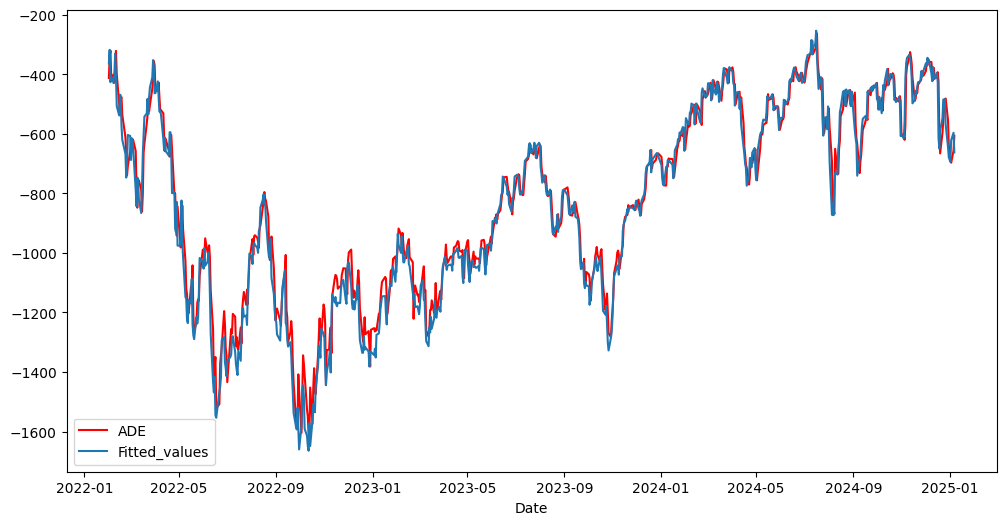

In [ ]:
#combine predictions
final_preds = test_predictions[10:] * weights_df
final_preds = final_preds.sum(dim=1)
final_preds

#visualize
final_preds = final_preds.detach().numpy()
plt.figure(figsize=(12, 6))
sns.lineplot(x = test_data[20:].index, y = final_preds, label = "ADE", color = "red")
sns.lineplot(data = test_data[20:])
plt.show()

#ADE library

In [11]:
#import libraries
import pandas as pd
import numpy as np
from google.colab import drive
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab import drive
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from joblib import Parallel, delayed, dump, load
import xgboost as xgb
import time
import yfinance as yf
import torch.nn.functional as F
from concurrent.futures import ThreadPoolExecutor
import threading

#suppress warnings
import warnings
warnings.filterwarnings('ignore')

def smape(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    numerator = np.abs(y_pred - y_true)
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
    smape_value = np.mean(numerator / denominator)  # Renamed variable to avoid conflict
    return smape_value

#deep learning meta model architecture
class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size=512, num_layers=3, dropout=0.3):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.num_classes = num_classes

        # LSTM layers
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout
        )

        # Fully connected layers
        self.fc1 = nn.Linear(hidden_size, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, self.num_classes)

        # Activation and dropout
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x):
        # LSTM output
        lstm_out, _ = self.lstm(x)

        # Pass only the last output
        lstm_out = lstm_out[:, -1, :]

        # Fully connected layers with ReLU and Dropout
        x = self.relu(self.fc1(lstm_out))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)  # Final prediction
        return x


#deep learning meta model architecture
class ParallelCNN_LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super().__init__()
        self.cnn = nn.Sequential(
            nn.Conv1d(in_channels=input_size, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2),
            nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.LazyLinear(out_features=128), #linear layer that automatically infer the input size
            nn.ReLU()
        )
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.fc_lstm = nn.Linear(hidden_size, 128)
        self.fc = nn.Linear(128*2, num_classes)

    def forward(self, x):
        #cnn takes input of shape (batch_size, channels, seq_len)
        x_cnn = x.permute(0, 2, 1)
        out_cnn = self.cnn(x_cnn)
        # lstm takes input of shape (batch_size, seq_len, input_size)
        out_lstm, _ = self.lstm(x)
        out_lstm = self.fc_lstm(out_lstm[:, -1, :])
        out = torch.cat([out_cnn, out_lstm], dim=1)
        out = self.fc(out)
        return out


class Custom_df(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __getitem__(self, index): #this method allows to retrieve a specific sample from the dataset based on its index (the index is passed to this method)
        input = torch.tensor(np.array(self.x[index]), dtype=torch.float32) #convert np array into a tensor
        target = torch.tensor(np.array(self.y[index]), dtype=torch.float32)
        return input, target

    def __len__(self):
        return len(self.x)


class DeviceDataLoader (): #receive a dataloader and move to the correct device
  def __init__(self, dl : DataLoader, device):
    self.dl = dl
    self.device = device

  def __iter__(self):
    for batch in iter(self.dl): #iter will reset the iterator every time the __iter__ mathod gets called
      yield ADE.to_device(batch, device)

  def __len__(self):
    return len(self.dl)



class ADE ():
    def __init__(self, trained_models: list, meta_model, train_data: pd.DataFrame, test_data: pd.DataFrame, window_size : int = 10, error_window = 10, k=3, temperature=1):
        self.trained_models = trained_models
        self.meta_model = self.get_meta_model(meta_model) #accept a string as an input
        self.train_data = pd.DataFrame(train_data)
        self.test_data = pd.DataFrame(test_data)
        self.MinMaxscaler = MinMaxScaler(feature_range=(-1, 1))
        self.Robustscaler = RobustScaler()
        # self.error_scaler = MinMaxScaler(feature_range=(-1, 1))
        self.window_size = window_size
        self.error_window = error_window
        self.k = k
        self.temperature = temperature
        self.test_predictions = []
        self.test_error_predictions = []
        self.device = self.get_device()
        self.lock = threading.Lock()
        self.ensemble_preds = None


        #if there are deep learning models
        if any(isinstance(model, torch.nn.Module) for model in trained_models):
            self.train_loader, self.test_loader = self.data_preprocessing_deep_learning(self.train_data, self.test_data, self.MinMaxscaler, self.window_size)

        #if there are machine learning models
        if any(not isinstance(model, torch.nn.Module) for model in trained_models):
            self.X_train, self.y_train, self.X_test, self.y_test = self.data_preprocessing_machine_learning(self.train_data, self.test_data, self.Robustscaler, self.window_size)


    def get_meta_model(self, meta_model): #get pre trained models
        if meta_model == "neural network":

            #new model istance

            num_classes = 1 # regression
            input_size = 1 #number of input features
            hidden_size = 512 #number of hidden layer in each cell, the more is better, but also will slow down the training
            num_layers = 1
            meta_model = ParallelCNN_LSTM(num_classes= num_classes, input_size = input_size, hidden_size = hidden_size, num_layers = num_layers)


            # num_classes = 1 # regression
            # input_size = 1 #number of input features
            # hidden_size = 512 #number of hidden layer in each cell, the more is better, but also will slow down the training
            # num_layers = 3
            # meta_model = LSTM(num_classes= num_classes, input_size = input_size, hidden_size = hidden_size, num_layers = num_layers)


            #load pre trained model
            model_path = f'/content/gdrive/MyDrive/università/Tesi/models/meta_models/ParallelCNN_LSTM'
            # model_path = f'/content/gdrive/MyDrive/università/Tesi/models/LSTM'
            meta_model.load_state_dict(torch.load(model_path, map_location=torch.device(device)))
            return meta_model


        elif meta_model == "linear booster":
            #load pre trained model
            model_path = f'/content/gdrive/MyDrive/università/Tesi/models/meta_models/Linear_booster_2.joblib'
            # model_path = f'/content/gdrive/MyDrive/università/Tesi/models/sp500/Linear_booster.joblib'
            # model_path = f'/content/gdrive/MyDrive/università/Tesi/models/meta_models/meta_model.joblib'

            meta_model = load(model_path)
            return meta_model


    def sliding_windows(self, data, seq_length): #helper function to genereate sliding windows
        X, y = [], []

        for i in range(len(data) - seq_length ):
            _x = data.iloc[i:i+seq_length]
            _y = data.iloc[i + seq_length]
            X.append(_x)
            y.append(_y)

        return np.array(X), np.array(y)


    def get_device(self):
        if torch.cuda.is_available():
            device = 'cuda'
        else:
            device = 'cpu'

        return device


    @staticmethod
    def to_device(data, device):
        if isinstance(data, (list, tuple)):
            return [to_device(x, device) for x in data]
        elif isinstance(data, torch.Tensor):  # Only move tensors to the device
            return data.to(device, non_blocking=True)
        else:
            return data  # For non-tensor types (e.g., strings), return as is


    @torch.no_grad()
    def inference(self, model, data_loader):
        model.eval()  # Set the model to evaluation mode
        predictions = []
        actuals = []

        for batch in data_loader:
            input, output = batch  # Unpack your batch into input and output
            outputs = model(input) # Perform the forward pass

            # Move outputs and actuals back to CPU and append to lists
            predictions.append(outputs.cpu())
            actuals.append(output.cpu())

        # Concatenate all predictions and actuals into single tensors
        predictions = torch.cat(predictions, dim=0)
        actuals = torch.cat(actuals, dim=0)

        return predictions, actuals


    def data_preprocessing_deep_learning (self, train_data, test_data, scaler, time_window):
        #scale data
        train_data_scaled = pd.DataFrame(scaler.fit_transform(train_data))
        test_data_scaled = pd.DataFrame(scaler.transform(test_data))

        #create sliding windows
        X_train, y_train = self.sliding_windows(train_data_scaled, time_window)
        X_test, y_test = self.sliding_windows(test_data_scaled, time_window)

        #move data to tensors
        train_df = Custom_df(X_train, y_train)
        test_df = Custom_df(X_test, y_test)

        #create dataloaders (to perform training/inference in batch)
        batch_size = 128
        num_workers = 2
        pin_memory = True if self.device == "cuda" else False
        train_loader = DataLoader(train_df, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=pin_memory, persistent_workers=True)
        test_loader = DataLoader(test_df, batch_size=batch_size*2, shuffle=False, num_workers=num_workers, pin_memory=pin_memory, persistent_workers=True)

        #move to device
        train_loader = DeviceDataLoader(train_loader, self.device)
        test_loader = DeviceDataLoader(test_loader, self.device)

        return train_loader, test_loader


    def data_preprocessing_machine_learning(self, train_data, test_data, scaler, time_window):
        #convert data to numpy arrays
        if isinstance(train_data, torch.Tensor):
            train_data = train_data.numpy()
        if isinstance(test_data, torch.Tensor):
            test_data = test_data.numpy()

        #scale data
        train_data_scaled = pd.DataFrame(scaler.fit_transform(train_data))
        test_data_scaled = pd.DataFrame(scaler.transform(test_data))

        #create sliding windows
        X_train, y_train = self.sliding_windows(train_data_scaled, time_window)
        X_test, y_test = self.sliding_windows(test_data_scaled, time_window)

        # Flatten the sliding windows
        X_train = X_train.reshape(X_train.shape[0], -1)
        X_test = X_test.reshape(X_test.shape[0], -1)


        return X_train, y_train, X_test, y_test




    def model_prediction(self, model):
        try:
            if isinstance(model, LinearBoostRegressor): #Linear Boost model predictions
                with self.lock:
                    test_prediction = model.predict(self.X_test)
                    train_prediction = model.predict(self.X_train)


                #inverse scale
                test_prediction = self.Robustscaler.inverse_transform(test_prediction.reshape(-1, 1))
                train_prediction = self.Robustscaler.inverse_transform(train_prediction.reshape(-1, 1))


                #visualize predictions
                # plt.figure(figsize=(12, 6))
                # # sns.lineplot(x=val_data.index, y=val_data['Residuals'].values, label="Val Data")
                # sns.lineplot(x= self.test_data[10:].index, y = self.test_data[10:].squeeze(), label="Test Data")
                # sns.lineplot(x= self.test_data[10:].index, y=test_prediction.squeeze(), label="XGBoost Predictions on Test set")
                # plt.title('XGBoost Predictions on Test set')
                # plt.xlabel('Date')
                # plt.ylabel('Close price residuals')
                # plt.xticks(rotation=45)  # Rotate x-axis labels
                # plt.tight_layout() # Automatically adjusts the layout
                # plt.legend()
                # plt.show()

                # r2 = r2_score(self.test_data[10:].values, test_prediction)
                # print(f"R2 score: {r2}")


                #convert to tensor
                test_prediction = torch.tensor(test_prediction, dtype=torch.float32).detach()
                train_prediction = torch.tensor(train_prediction, dtype=torch.float32).detach()


                #convert actual to tensors
                test_actual = torch.tensor(self.test_data[self.window_size:].values, dtype=torch.float32)
                train_actual = torch.tensor(self.train_data[self.window_size:].values, dtype=torch.float32)


                #compute train / test error
                # ae_train_errors = torch.abs(train_actual - train_prediction)
                # ae_test_errors = torch.abs(test_actual - test_prediction)

                ae_train_errors = (train_actual - train_prediction)**2
                ae_test_errors = (test_actual - test_prediction)**2



                #save into a csv
                errori = pd.DataFrame(ae_test_errors.numpy().ravel())
                errori.index = self.test_data[self.window_size:].index
                errori.to_csv(f'/content/test_errori.csv')

                train_errori = pd.DataFrame(ae_train_errors.numpy().ravel())
                train_errori.index = self.train_data[self.window_size:].index
                train_errori.to_csv(f'/content/train_errori.csv')


                #test error prediction
                if isinstance(self.meta_model, torch.nn.Module):
                    # print("meta modeling")

                    #data preprocessing
                    # error_scaler = RobustScaler()
                    error_scaler = MinMaxScaler(feature_range=(-1, 1))
                    ae_train_dataloader, ae_test_dataloader = self.data_preprocessing_deep_learning(ae_train_errors, ae_test_errors, error_scaler, self.error_window)

                    #test prediction
                    ae_test_prediction, ae_test_actual = self.inference(self.meta_model, ae_test_dataloader)

                    ## Inverse Scale
                    ae_test_prediction = error_scaler.inverse_transform(ae_test_prediction)
                    ae_test_actual = error_scaler.inverse_transform(ae_test_actual)


                    #convert to tensor
                    ae_test_prediction = torch.tensor(ae_test_prediction, dtype=torch.float32).detach()
                    ae_test_actual = torch.tensor(ae_test_actual, dtype=torch.float32).detach()


                    #visualize
                    # ae_test_prediction = pd.DataFrame(ae_test_prediction)
                    # ae_test_prediction.index = pd.to_datetime(self.test_data[self.window_size*2:].index)

                    # ae_test_actual = pd.DataFrame(ae_test_actual)
                    # ae_test_actual.index = pd.to_datetime(self.test_data[self.window_size*2:].index)

                    # print(f"{model} first error prediction: {ae_test_prediction.iloc[0]}")
                    # plt.figure(figsize=(21, 6))
                    # sns.lineplot(x=ae_test_actual.index, y = ae_test_actual[0], color = "green", label = "Train set")
                    # sns.lineplot(x=ae_test_prediction.index, y = ae_test_prediction[0], color = "red", label = "predictions")
                    # plt.suptitle(f'Predictions on the Test Set {model.__class__.__name__} {name}')
                    # plt.show()

                    # r2 = r2_score(ae_test_actual[0], ae_test_prediction[0])
                    # print(f"R2 score: {r2}")

                    return (test_prediction, ae_test_prediction)

                elif(isinstance(self.meta_model, LinearBoostRegressor)):
                    #data preprocessing
                    # error_scaler = MinMaxScaler(feature_range=(-1, 1))
                    error_scaler = RobustScaler()
                    ae_X_train, ae_y_test, ae_X_test, ae_y_test = self.data_preprocessing_machine_learning(ae_train_errors, ae_test_errors, error_scaler, self.error_window)

                    #predict
                    ae_test_prediction = self.meta_model.predict(ae_X_test)

                    #unscale
                    ae_test_prediction = error_scaler.inverse_transform(ae_test_prediction.reshape(-1, 1))

                    #visualize
                    plt.figure(figsize=(20, 6))
                    sns.lineplot(x=self.test_data[10:].index, y = ae_test_errors.numpy().ravel(), color = "green", label = "Train set")
                    sns.lineplot(x=self.test_data[20:].index, y = ae_test_prediction.ravel(), color = "red", label = "predictions")
                    plt.suptitle(f'Predictions on the Test Set {model.__class__.__name__} {name}')
                    plt.show()

                    # r2 = r2_score(self.test_data[10:].values, test_prediction)
                    # print(f"R2 score: {r2}")

                    #convert to tensor
                    ae_test_prediction = torch.tensor(ae_test_prediction, dtype=torch.float32).detach()

                    return (test_prediction, ae_test_prediction)


                else:
                    raise ValueError(f"Unsupported meta model type: {type(model)}")


                return (test_prediction, 0)


            elif isinstance(model, torch.nn.Module):

                #train predictions
                with self.lock: #the lock prevents multiple threads from accessing shared data at the same time
                    train_prediction, train_actual = self.inference(model, self.train_loader)


                # Inverse Scale
                train_prediction = self.MinMaxscaler.inverse_transform(train_prediction)
                train_actual = self.MinMaxscaler.inverse_transform(train_actual)


                #convert to tensors
                train_prediction = torch.tensor(train_prediction, dtype=torch.float32).detach()
                train_actual = torch.tensor(train_actual, dtype=torch.float32).detach()


                #test predictions
                with self.lock:
                    test_prediction, test_actual = self.inference(model, self.test_loader)

                # Inverse Scale
                test_prediction = self.MinMaxscaler.inverse_transform(test_prediction)
                test_actual = self.MinMaxscaler.inverse_transform(test_actual)

                #convert to tensors
                test_prediction = torch.tensor(test_prediction, dtype=torch.float32).detach()
                test_actual = torch.tensor(test_actual, dtype=torch.float32).detach()


                # #visualize predictions
                # test_prediction = pd.DataFrame(test_prediction)
                # test_prediction.index = pd.to_datetime(self.test_data[self.window_size:].index)
                # test_actual = pd.DataFrame(test_actual)
                # test_actual.index = pd.to_datetime(self.test_data[self.window_size:].index)
                # model_name = type(model).__name__

                # plt.figure(figsize=(12, 6))
                # sns.lineplot(x= test_actual.index, y = test_actual.iloc[:,0], label="Test Data")
                # sns.lineplot(x=test_prediction.index, y=test_prediction.iloc[:,0], label=f"{model_name} predictions on Test Data")
                # plt.title(f'{model_name} predictions on Test Data')
                # plt.xlabel('Date')
                # plt.ylabel('Close price residuals')
                # plt.xticks(rotation=45)  # Rotate x-axis labels
                # plt.tight_layout() # Automatically adjusts the layout
                # plt.legend()
                # plt.show()

                # r2 = r2_score(test_actual, test_prediction)
                # print(f"R2 score: {r2}")

                #compute absolute errors
                # ae_train_errors = torch.abs(train_actual - train_prediction)
                # ae_test_errors = torch.abs(test_actual - test_prediction)

                ae_train_errors = (train_actual - train_prediction)**2
                ae_test_errors = (test_actual - test_prediction)**2



                if isinstance(self.meta_model, torch.nn.Module): #test error prediction
                    # print("meta modeling")

                    #data preprocessing
                    # error_scaler = RobustScaler()
                    error_scaler = MinMaxScaler(feature_range=(-1, 1))
                    ae_train_dataloader, ae_test_dataloader = self.data_preprocessing_deep_learning(ae_train_errors, ae_test_errors, error_scaler, self.error_window)

                    #test prediction
                    ae_test_prediction, ae_test_actual = self.inference(self.meta_model, ae_test_dataloader)

                    ## Inverse Scale
                    ae_test_prediction = error_scaler.inverse_transform(ae_test_prediction)
                    ae_test_actual = error_scaler.inverse_transform(ae_test_actual)


                    #convert to tensor
                    ae_test_prediction = torch.tensor(ae_test_prediction, dtype=torch.float32).detach()
                    ae_test_actual = torch.tensor(ae_test_actual, dtype=torch.float32).detach()


                    #visualize
                    # ae_test_prediction = pd.DataFrame(ae_test_prediction)
                    # ae_test_prediction.index = pd.to_datetime(self.test_data[self.window_size*2:].index)

                    # ae_test_actual = pd.DataFrame(ae_test_actual)
                    # ae_test_actual.index = pd.to_datetime(self.test_data[self.window_size*2:].index)

                    # print(f"{model} first error prediction: {ae_test_prediction.iloc[0]}")
                    # plt.figure(figsize=(21, 6))
                    # sns.lineplot(x=ae_test_actual.index, y = ae_test_actual[0], color = "green", label = "Train set")
                    # sns.lineplot(x=ae_test_prediction.index, y = ae_test_prediction[0], color = "red", label = "predictions")
                    # plt.suptitle(f'Predictions on the Test Set {model.__class__.__name__} {name}')
                    # plt.show()

                    # r2 = r2_score(ae_test_actual[0], ae_test_prediction[0])
                    # print(f"R2 score: {r2}")

                    return (test_prediction, ae_test_prediction)


                elif(isinstance(self.meta_model, LinearBoostRegressor)):
                    #data preprocessing
                    # error_scaler = MinMaxScaler(feature_range=(-1, 1))
                    error_scaler = RobustScaler()
                    ae_X_train, ae_y_test, ae_X_test, ae_y_test = self.data_preprocessing_machine_learning(ae_train_errors, ae_test_errors, error_scaler, self.error_window)

                    #predict
                    ae_test_prediction = self.meta_model.predict(ae_X_test)

                    #unscale
                    ae_test_prediction = error_scaler.inverse_transform(ae_test_prediction.reshape(-1, 1))

                    #visualize
                    plt.figure(figsize=(20, 6))
                    sns.lineplot(x=self.test_data[10:].index, y = ae_test_errors.numpy().ravel(), color = "green", label = "Train set")
                    sns.lineplot(x=self.test_data[20:].index, y = ae_test_prediction.ravel(), color = "red", label = "predictions")
                    plt.suptitle(f'Predictions on the Test Set {model.__class__.__name__} {name}')
                    plt.show()

                    r2 = r2_score(self.test_data[10:].values, test_prediction)
                    print(f"R2 score: {r2}")

                    #convert to tensor
                    ae_test_prediction = torch.tensor(ae_test_prediction, dtype=torch.float32).detach()

                    return (test_prediction, ae_test_prediction)

                else:
                    raise ValueError(f"Unsupported meta model type: {type(model)}")

            else:
                raise ValueError(f"Unsupported base model type: {type(model)}")


        except Exception as e:
            print(f"Error processing model {model}: {e}")
            raise e


    def predict(self):
        #parallel execution
        with ThreadPoolExecutor() as executor: #it creates a pool of worker threads (the with statement ensures that the pool of threads is cleaned up automatically after the execution)
            results = list(executor.map(self.model_prediction, self.trained_models)) #task each thread will execute


        # Combine predictions into a single tensor
        self.test_predictions = torch.stack([item[0] for item in results], dim=1).squeeze()
        self.test_error_predictions = torch.stack([item[1] for item in results], dim=1).squeeze()
        print("test error predictions")
        print(self.test_error_predictions)


        #filter the 3 best errors
        best_kerrors, indices = torch.topk(self.test_error_predictions, k=self.k, largest=False, sorted=False)
        print("best k errors")
        print(best_kerrors)


        #normalize the errors
        std = best_kerrors.std(dim=1, keepdim=True) + 1e-8 #for numerical stability (to avoid division by zero)
        print("std")
        print(std[:10])
        mean = best_kerrors.mean(dim=1, keepdim=True)
        print("mean")
        print(mean[:10])
        normalized_errors = (self.test_error_predictions - mean) / std
        print("unmasked normalized errors")
        print(normalized_errors)


        #apply mask
        mask = torch.zeros_like(self.test_error_predictions, dtype=torch.bool)
        mask.scatter_(dim=1, index=indices, value=True)
        normalized_errors[~mask] = float('inf')
        print("normalized errors")
        print(normalized_errors)


        #apply softmax
        weights_df = F.softmax(-normalized_errors, dim=1)
        print("weights")
        print(weights_df)

        weights_df = F.softmax(-normalized_errors * self.temperature, dim=1)
        print("temperature weights")
        print(weights_df)


        #compute weights using softmax function
        # normalized_errors = (self.test_error_predictions - self.test_error_predictions.mean(dim=1, keepdim=True)) / self.test_error_predictions.std(dim=1, keepdim=True)
        # weights_df = F.softmax(-normalized_errors, dim=1)
        # print(weights_df)


        #combine predictions
        self.ensemble_preds = self.test_predictions[self.error_window:] * weights_df
        self.ensemble_preds = self.ensemble_preds.sum(dim=1)
        return self.ensemble_preds

Linear booster meta model

ensembling predictions on eur_usd dataset:


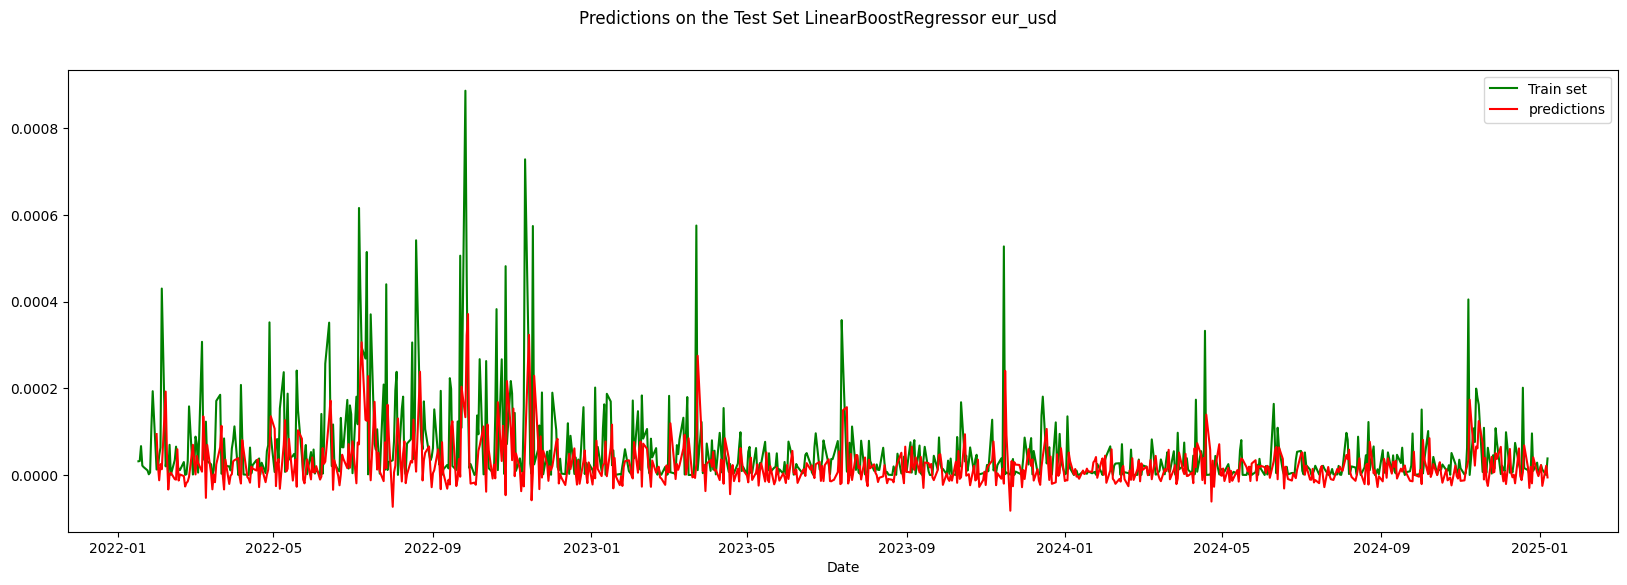

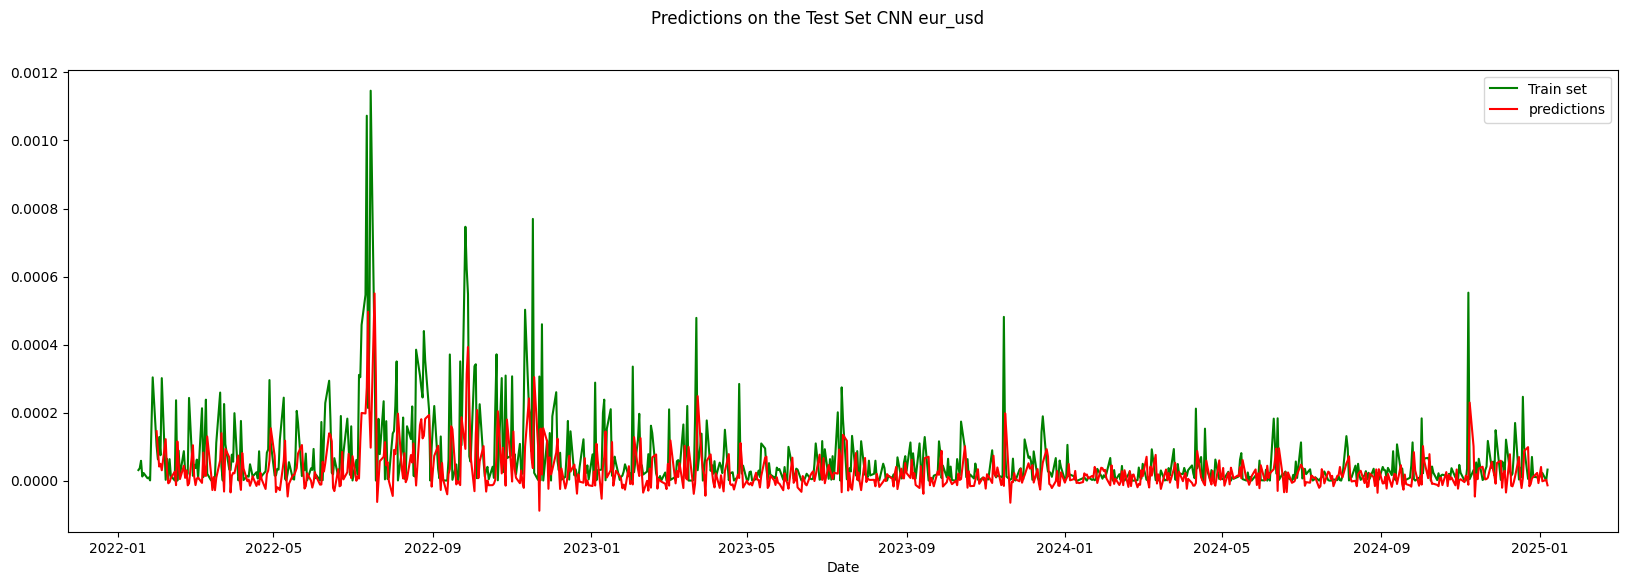

R2 score: 0.9494768036696593


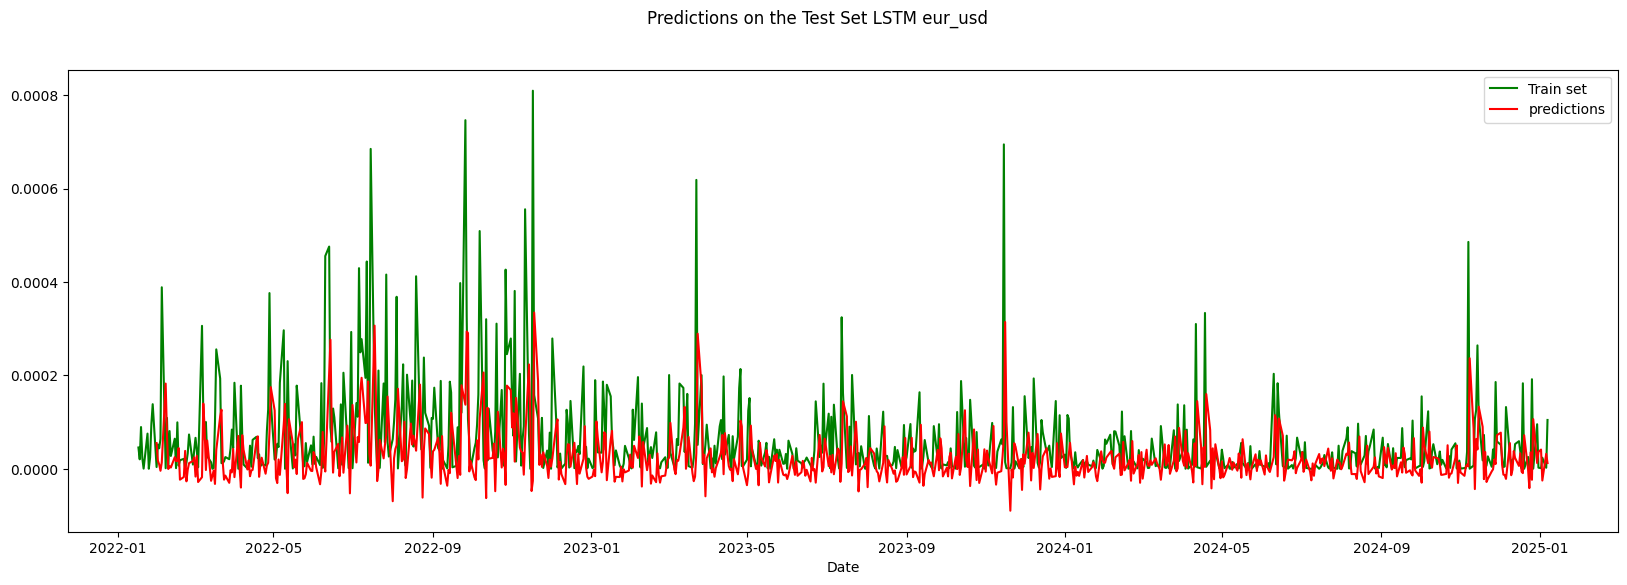

R2 score: 0.951613879586903


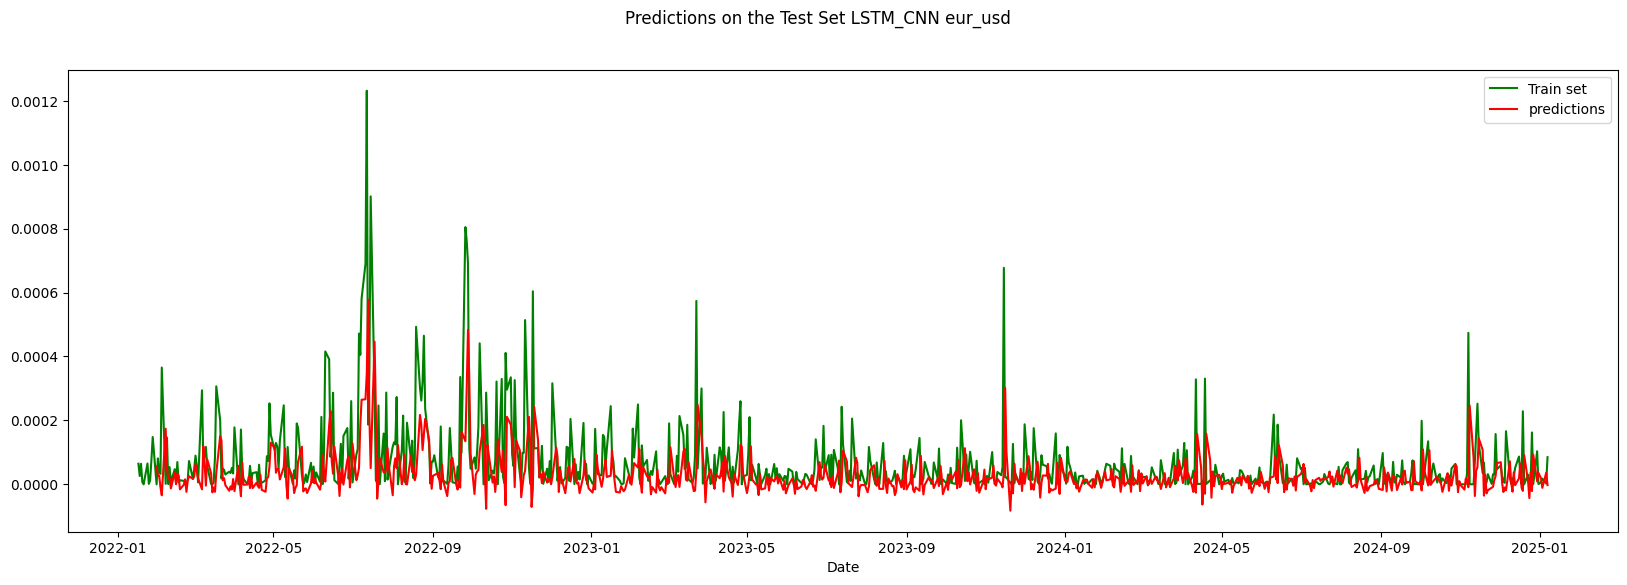

R2 score: 0.947316684164405


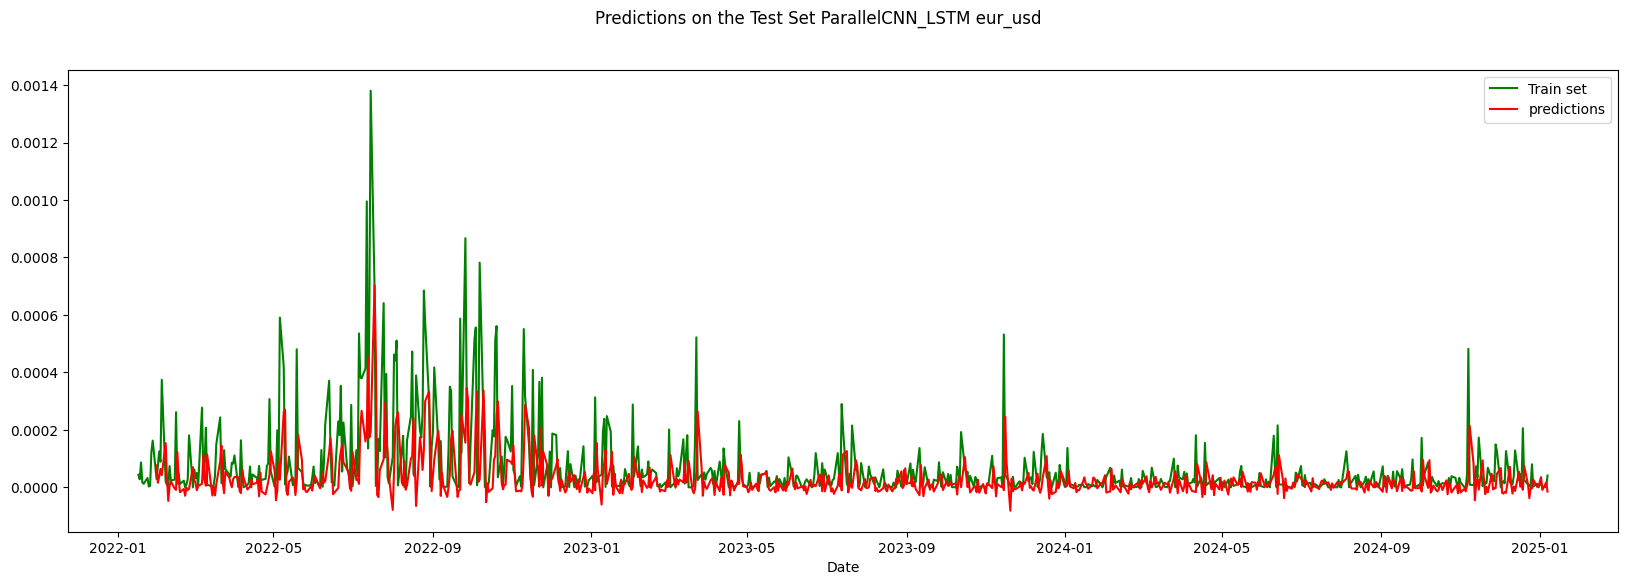

R2 score: 0.9451984428149969
test error predictions
tensor([[ 9.4395e-05,  1.4504e-04,  5.4993e-05,  5.6396e-05,  7.6044e-05],
        [ 2.2628e-05,  8.8303e-05,  1.7311e-05,  2.7845e-05,  1.5929e-05],
        [-1.2194e-05,  4.1293e-05,  9.3606e-06,  2.7320e-05,  3.7540e-05],
        ...,
        [-2.5101e-05, -1.9552e-06, -2.5189e-05, -1.0988e-05, -8.9154e-06],
        [ 2.1329e-05,  2.4134e-06,  3.1895e-05,  3.6491e-05,  1.6796e-05],
        [-5.5760e-06, -1.3831e-05,  1.2251e-05, -2.3977e-06, -1.4748e-05]])
best k errors
tensor([[ 7.6044e-05,  5.6396e-05,  5.4993e-05,  9.4395e-05],
        [ 1.7311e-05,  1.5929e-05,  2.2628e-05,  2.7845e-05],
        [ 9.3606e-06, -1.2194e-05,  2.7320e-05,  3.7540e-05],
        ...,
        [-2.5101e-05, -2.5189e-05, -1.0988e-05, -8.9154e-06],
        [ 1.6796e-05,  2.4134e-06,  2.1329e-05,  3.1895e-05],
        [-1.3831e-05, -1.4748e-05, -5.5760e-06, -2.3977e-06]])
std
tensor([[1.8639e-05],
        [5.4507e-06],
        [2.1843e-05],
        [2.754

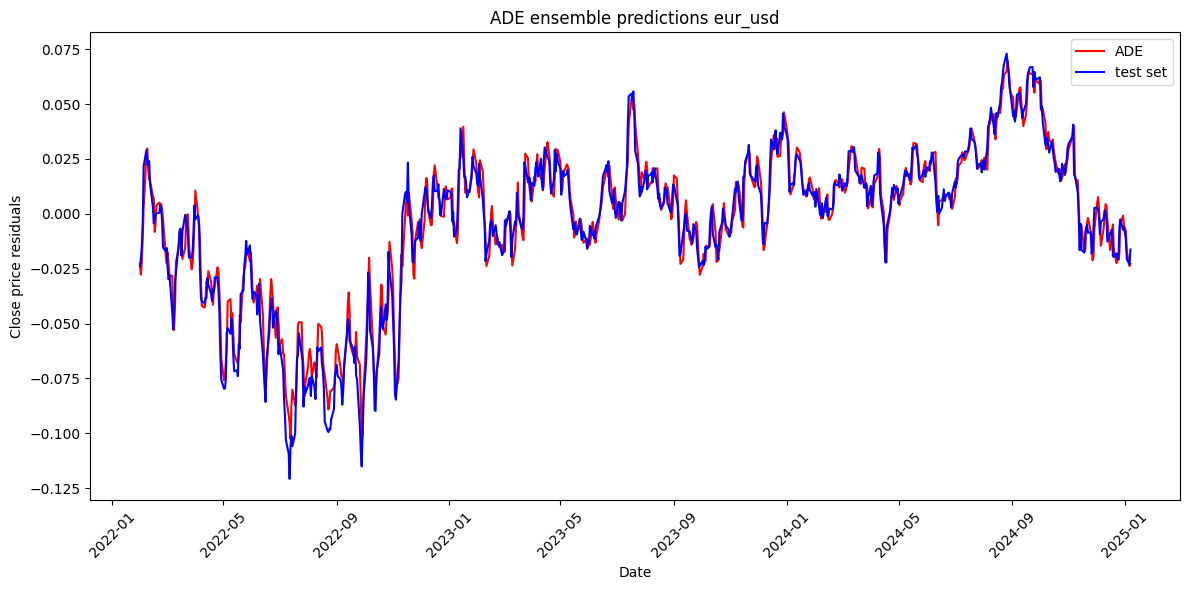

MSE: 5.615841774448743e-05
RMSE: 0.007493892029145298
MAE: 0.0057695151574620514
r2:  0.956105260214284
MAPE: 2.4993470502292134
SMAPE: 0.45789569523619433


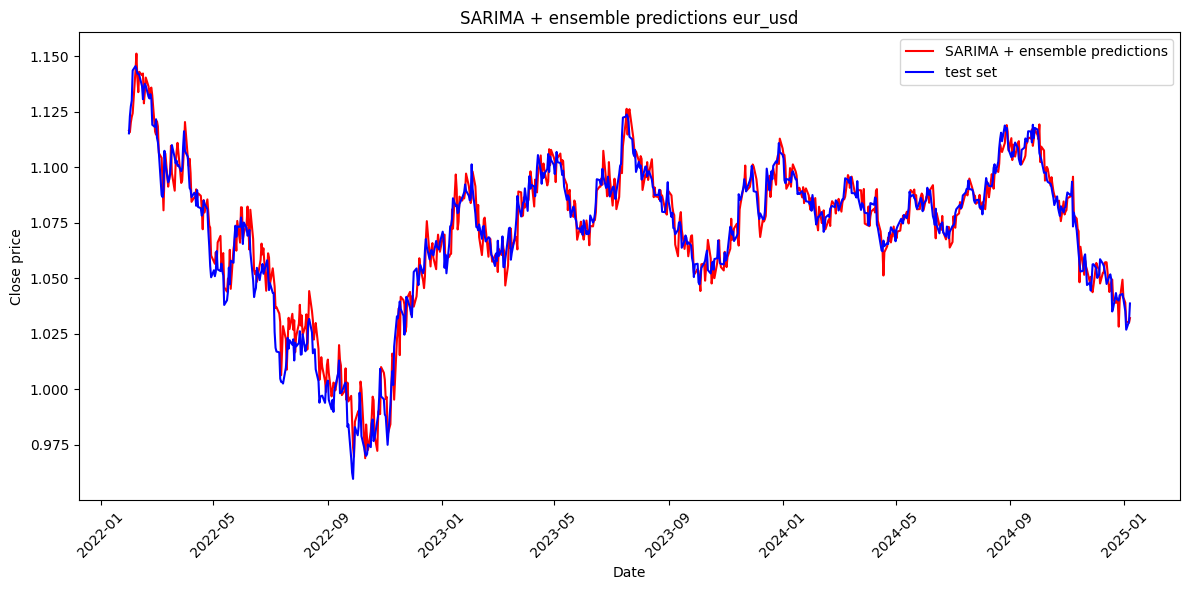

MSE: 5.6158417744488585e-05
RMSE: 0.007493892029145375
MAE: 0.005769515157462084
r2:  0.950501092064945
MAPE: 0.005440448882639984
SMAPE: 0.005432671826638468


In [12]:
#using the class
train_data = {}
test_data = {}

trained_models = [Linear_booster_model, CNN_model, LSTM_model, LSTM_CNN_model, parallelCNNLSTM_model]

for name , _ in datasets.items():

    if name == 'sp500':
        continue

    print(f"ensembling predictions on {name} dataset:")
    # meta_model = "neural network"
    meta_model = "linear booster"
    train_data[name] = val_residuals[name]
    train_data[name].index = pd.to_datetime(val_residuals[name].index)

    test_data[name] = test_residuals[name]
    test_data[name].index = pd.to_datetime(test_residuals[name].index)
    window_size = 10
    error_window = 10

    if name == 'eur_usd':
        k=4
        temperature = 0.35 #to control weight sharpness
    elif name == 'sp500':
        temperature = 1
        k=3 #number of models to make the ensemble at each time step


    ade = ADE([trained_model[name] for trained_model in trained_models], meta_model, train_data[name], test_data[name], window_size, error_window, k, temperature) #k represent the number of model to select from the batch of models
    final_preds = ade.predict()


    #visualize
    ensemble_preds = pd.DataFrame(final_preds.detach().numpy(), index = test_data[name][window_size*2:].index)
    # ensemble_preds.index = pd.to_datetime(test_data[name][window_size*2:].index)

    plt.figure(figsize=(12, 6))
    plt.title(f"ADE ensemble predictions {name}")
    sns.lineplot(x = ensemble_preds.index, y = ensemble_preds.squeeze(), label = "ADE", color = "red")
    sns.lineplot(x = test_data[name][window_size*2:].index, y = test_data[name][window_size*2:].squeeze(), label = "test set", color = "blue")
    plt.ylabel('Close price residuals')
    plt.xlabel('Date')
    plt.xticks(rotation=45)  # Rotate x-axis labels
    plt.tight_layout() # Automatically adjusts the layout
    plt.legend()
    plt.show()


    #compute metrics
    mse = mean_squared_error(test_data[name][window_size*2:], ensemble_preds)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(test_data[name][window_size*2:], ensemble_preds)
    r2 = r2_score(test_data[name][window_size*2:], ensemble_preds)
    mape = mean_absolute_percentage_error(test_data[name][window_size*2:], ensemble_preds)
    smape_value = smape(test_data[name][window_size*2:], ensemble_preds)

    print(f"MSE: {mse}")
    print(f"RMSE: {rmse}")
    print(f"MAE: {mae}")
    print(f"r2:  {r2}")
    print(f"MAPE: {mape}")
    print(f"SMAPE: {smape_value}")


    #combine ensemble predictions with ARIMA model
    final_preds = SARIMA_test_predictions[name][window_size*2:] + ensemble_preds.iloc[:,0]

    #visualize
    plt.figure(figsize=(12, 6))
    plt.title(f"SARIMA + ensemble predictions {name}")
    sns.lineplot(x = final_preds.index, y = final_preds.squeeze(), label = "SARIMA + ensemble predictions", color = "red")
    sns.lineplot(x = Close_price[name].loc[final_preds.index].index, y = Close_price[name].loc[final_preds.index].squeeze(), label = "test set", color = "blue")
    plt.ylabel('Close price')
    plt.xlabel('Date')
    plt.xticks(rotation=45)  # Rotate x-axis labels
    plt.tight_layout() # Automatically adjusts the layout
    plt.legend()
    plt.show()


    #compute metrics
    mse = mean_squared_error(Close_price[name].loc[final_preds.index], final_preds)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(Close_price[name].loc[final_preds.index], final_preds)
    r2 = r2_score(Close_price[name].loc[final_preds.index], final_preds)
    mape = mean_absolute_percentage_error(Close_price[name].loc[final_preds.index], final_preds)
    smape_value = smape(Close_price[name].loc[final_preds.index], final_preds)

    print(f"MSE: {mse}")
    print(f"RMSE: {rmse}")
    print(f"MAE: {mae}")
    print(f"r2:  {r2}")
    print(f"MAPE: {mape}")
    print(f"SMAPE: {smape_value}")

Neural network meta model

ensembling predictions on eur_usd dataset:
test error predictions
tensor([[1.9063e-04, 2.7252e-04, 1.6091e-04, 1.6547e-04, 1.5258e-04],
        [3.0898e-05, 9.7187e-05, 3.5420e-05, 2.8342e-05, 3.6386e-05],
        [3.4761e-05, 8.4533e-05, 8.2013e-05, 1.0795e-04, 8.7685e-05],
        ...,
        [4.8952e-05, 3.8609e-05, 3.3855e-05, 3.4784e-05, 3.4865e-05],
        [3.9877e-05, 4.3063e-05, 5.7441e-05, 4.8780e-05, 2.2614e-05],
        [2.7428e-05, 2.1920e-05, 3.6928e-05, 3.3693e-05, 2.1239e-05]])
best k errors
tensor([[1.6091e-04, 1.5258e-04, 1.6547e-04, 1.9063e-04],
        [3.0898e-05, 2.8342e-05, 3.5420e-05, 3.6386e-05],
        [8.4533e-05, 3.4761e-05, 8.2013e-05, 8.7685e-05],
        ...,
        [3.4865e-05, 3.4784e-05, 3.3855e-05, 3.8609e-05],
        [4.3063e-05, 3.9877e-05, 2.2614e-05, 4.8780e-05],
        [2.1920e-05, 2.1239e-05, 2.7428e-05, 3.3693e-05]])
std
tensor([[1.6395e-05],
        [3.8053e-06],
        [2.5109e-05],
        [3.1959e-05],
        [1.4564e-05],
        [4

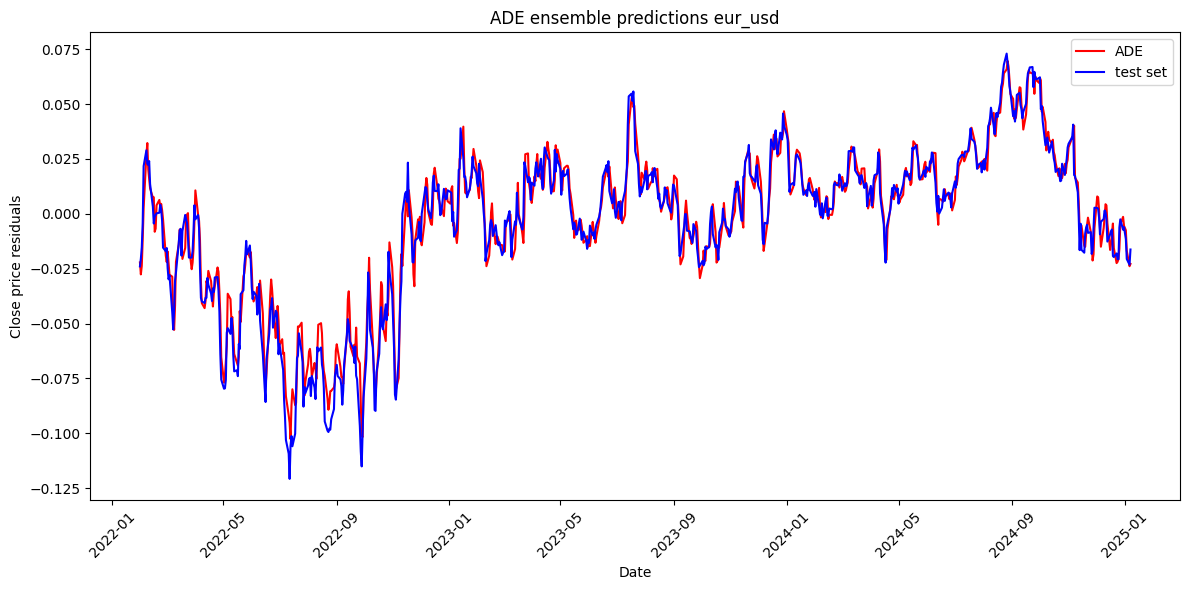

MSE: 5.633500919645386e-05
RMSE: 0.007505665140176043
MAE: 0.0057665818507117205
r2:  0.9559672321831576
MAPE: 2.4906022574191145
SMAPE: 0.4583985913064385


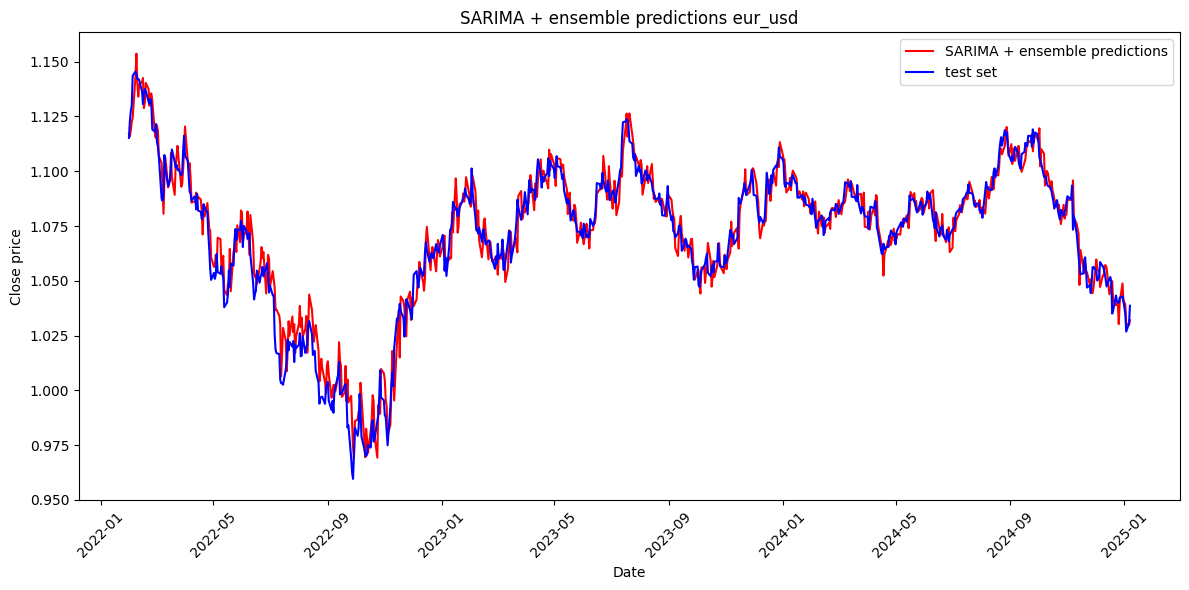

MSE: 5.633500919645504e-05
RMSE: 0.0075056651401761215
MAE: 0.005766581850711766
r2:  0.9503454415966078
MAPE: 0.005438690062259403
SMAPE: 0.00543095659716342


In [59]:
#using the class
train_data = {}
test_data = {}

trained_models = [Linear_booster_model, CNN_model, LSTM_model, LSTM_CNN_model, parallelCNNLSTM_model]

for name , _ in datasets.items():

    if name == 'sp500':
        continue

    print(f"ensembling predictions on {name} dataset:")
    meta_model = "neural network"
    # meta_model = "linear booster"
    train_data[name] = val_residuals[name]
    train_data[name].index = pd.to_datetime(val_residuals[name].index)

    test_data[name] = test_residuals[name]
    test_data[name].index = pd.to_datetime(test_residuals[name].index)
    window_size = 10
    error_window = 10

    if name == 'eur_usd':
        k=4
        temperature = 0.35 #to control weight sharpness
    elif name == 'sp500':
        temperature = 1
        k=3 #number of models to make the ensemble at each time step


    ade = ADE([trained_model[name] for trained_model in trained_models], meta_model, train_data[name], test_data[name], window_size, error_window, k, temperature) #k represent the number of model to select from the batch of models
    final_preds = ade.predict()


    #visualize
    ensemble_preds = pd.DataFrame(final_preds.detach().numpy(), index = test_data[name][window_size*2:].index)
    # ensemble_preds.index = pd.to_datetime(test_data[name][window_size*2:].index)

    plt.figure(figsize=(12, 6))
    plt.title(f"ADE ensemble predictions {name}")
    sns.lineplot(x = ensemble_preds.index, y = ensemble_preds.squeeze(), label = "ADE", color = "red")
    sns.lineplot(x = test_data[name][window_size*2:].index, y = test_data[name][window_size*2:].squeeze(), label = "test set", color = "blue")
    plt.ylabel('Close price residuals')
    plt.xlabel('Date')
    plt.xticks(rotation=45)  # Rotate x-axis labels
    plt.tight_layout() # Automatically adjusts the layout
    plt.legend()
    plt.show()


    #compute metrics
    mse = mean_squared_error(test_data[name][window_size*2:], ensemble_preds)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(test_data[name][window_size*2:], ensemble_preds)
    r2 = r2_score(test_data[name][window_size*2:], ensemble_preds)
    mape = mean_absolute_percentage_error(test_data[name][window_size*2:], ensemble_preds)
    smape_value = smape(test_data[name][window_size*2:], ensemble_preds)

    print(f"MSE: {mse}")
    print(f"RMSE: {rmse}")
    print(f"MAE: {mae}")
    print(f"r2:  {r2}")
    print(f"MAPE: {mape}")
    print(f"SMAPE: {smape_value}")


    #combine ensemble predictions with ARIMA model
    final_preds = SARIMA_test_predictions[name][window_size*2:] + ensemble_preds.iloc[:,0]

    #visualize
    plt.figure(figsize=(12, 6))
    plt.title(f"SARIMA + ensemble predictions {name}")
    sns.lineplot(x = final_preds.index, y = final_preds.squeeze(), label = "SARIMA + ensemble predictions", color = "red")
    sns.lineplot(x = Close_price[name].loc[final_preds.index].index, y = Close_price[name].loc[final_preds.index].squeeze(), label = "test set", color = "blue")
    plt.ylabel('Close price')
    plt.xlabel('Date')
    plt.xticks(rotation=45)  # Rotate x-axis labels
    plt.tight_layout() # Automatically adjusts the layout
    plt.legend()
    plt.show()


    #compute metrics
    mse = mean_squared_error(Close_price[name].loc[final_preds.index], final_preds)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(Close_price[name].loc[final_preds.index], final_preds)
    r2 = r2_score(Close_price[name].loc[final_preds.index], final_preds)
    mape = mean_absolute_percentage_error(Close_price[name].loc[final_preds.index], final_preds)
    smape_value = smape(Close_price[name].loc[final_preds.index], final_preds)

    print(f"MSE: {mse}")
    print(f"RMSE: {rmse}")
    print(f"MAE: {mae}")
    print(f"r2:  {r2}")
    print(f"MAPE: {mape}")
    print(f"SMAPE: {smape_value}")

In [68]:
!pip install arch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 985.3/985.3 kB 19.1 MB/s eta 0:00:00


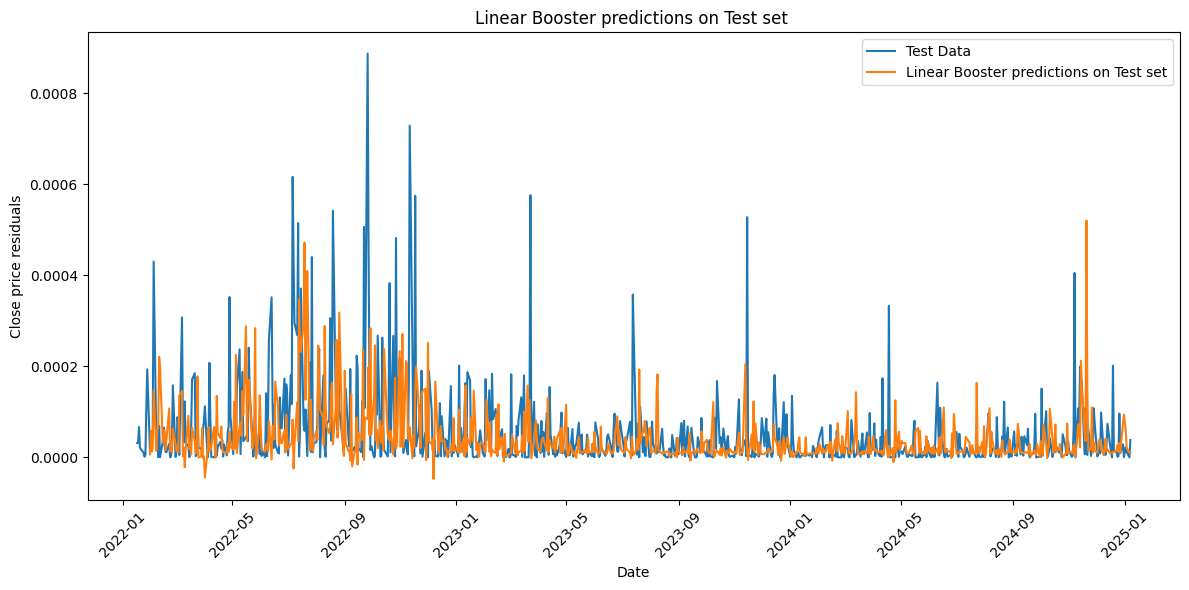

RMSE: 0.00010675839573414329
R2: -0.2785850763320923


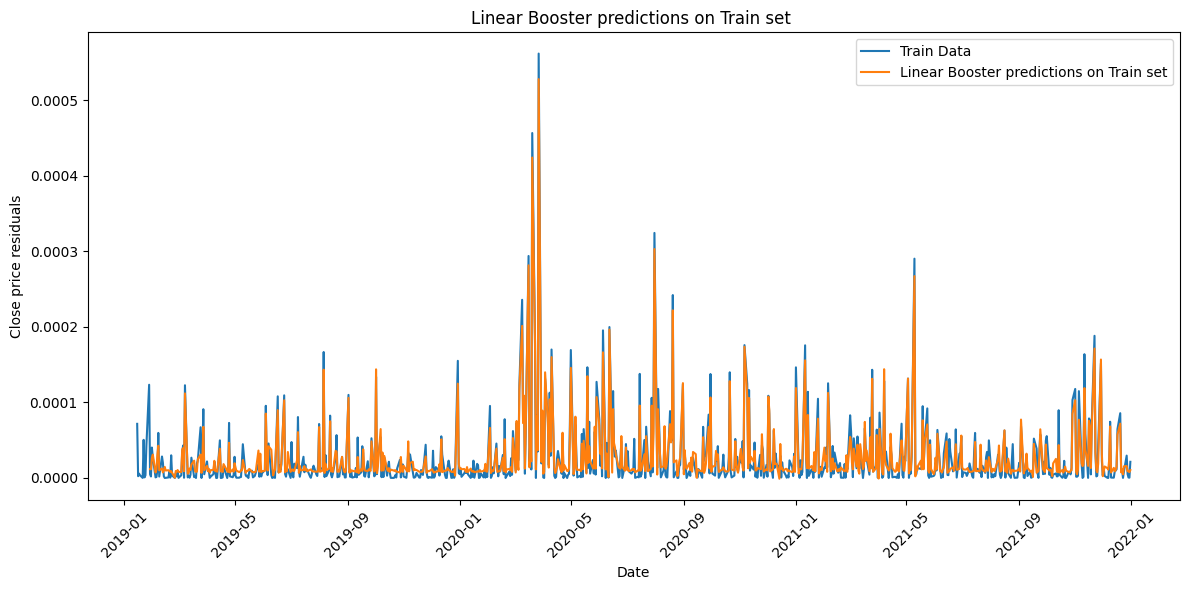

RMSE: 1.2128140709764126e-05
R2: 0.935643196105957


In [94]:
from arch import arch_model
from sklearn.linear_model import Ridge

def sliding_windows(data, seq_length):
    X, y = [], []

    for i in range(len(data) - seq_length ):
        _x = data.iloc[i:i+seq_length]
        _y = data.iloc[i + seq_length]
        X.append(_x)
        y.append(_y)

    return np.array(X), np.array(y)

train_errors = pd.read_csv("train_errori.csv", index_col=0)
test_errors = pd.read_csv("test_errori.csv", index_col=0)

train_errors.index = pd.to_datetime(train_errors.index)
test_errors.index = pd.to_datetime(test_errors.index)

scaler = RobustScaler()
train_errors_scaled = pd.DataFrame(scaler.fit_transform(train_errors), index = train_errors.index)
test_errors_scaled = pd.DataFrame(scaler.transform(test_errors), index = test_errors.index)


X_train, y_train = sliding_windows(train_errors_scaled, 10)
X_test, y_test = sliding_windows(test_errors_scaled, 10)

# Flatten the sliding windows
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)


#train model
best_params = {"n_estimators": 300,  "max_depth": 10,  "min_samples_split" : 10, "min_samples_leaf" : 0.005 }
ridge = Ridge(alpha=4)
model = LinearBoostRegressor(base_estimator=ridge, **best_params)
model.fit(X_train, y_train)


#predict
y_test_pred = model.predict(X_test)
y_train_pred = model.predict(X_train)


#inverse scale
y_test_pred = scaler.inverse_transform(y_test_pred.reshape(-1, 1))
y_train_pred = scaler.inverse_transform(y_train_pred.reshape(-1, 1))


#visualize
plt.figure(figsize=(12, 6))
sns.lineplot(x= test_errors.index, y = test_errors.squeeze(), label="Test Data")
sns.lineplot(x=test_errors[10:].index, y=y_test_pred.squeeze(), label="Linear Booster predictions on Test set")
plt.title(f'Linear Booster predictions on Test set ')
plt.xlabel('Date')
plt.ylabel('Close price residuals')
plt.xticks(rotation=45)  # Rotate x-axis labels
plt.tight_layout() # Automatically adjusts the layout
plt.legend()
plt.show()


#compute metrics
rmse = np.sqrt(mean_squared_error(test_errors[10:], y_test_pred))
r2 = r2_score(test_errors[10:], y_test_pred)
print(f"RMSE: {rmse}")
print(f"R2: {r2}")



#fitted values
plt.figure(figsize=(12, 6))
sns.lineplot(x= train_errors.index, y = train_errors.squeeze(), label="Train Data")
sns.lineplot(x=train_errors[10:].index, y=y_train_pred.squeeze(), label="Linear Booster predictions on Train set")
plt.title(f'Linear Booster predictions on Train set ')
plt.xlabel('Date')
plt.ylabel('Close price residuals')
plt.xticks(rotation=45)  # Rotate x-axis labels
plt.tight_layout() # Automatically adjusts the layout
plt.legend()
plt.show()

#compute metrics
rmse = np.sqrt(mean_squared_error(train_errors[10:], y_train_pred))
r2 = r2_score(train_errors[10:], y_train_pred)
print(f"RMSE: {rmse}")
print(f"R2: {r2}")




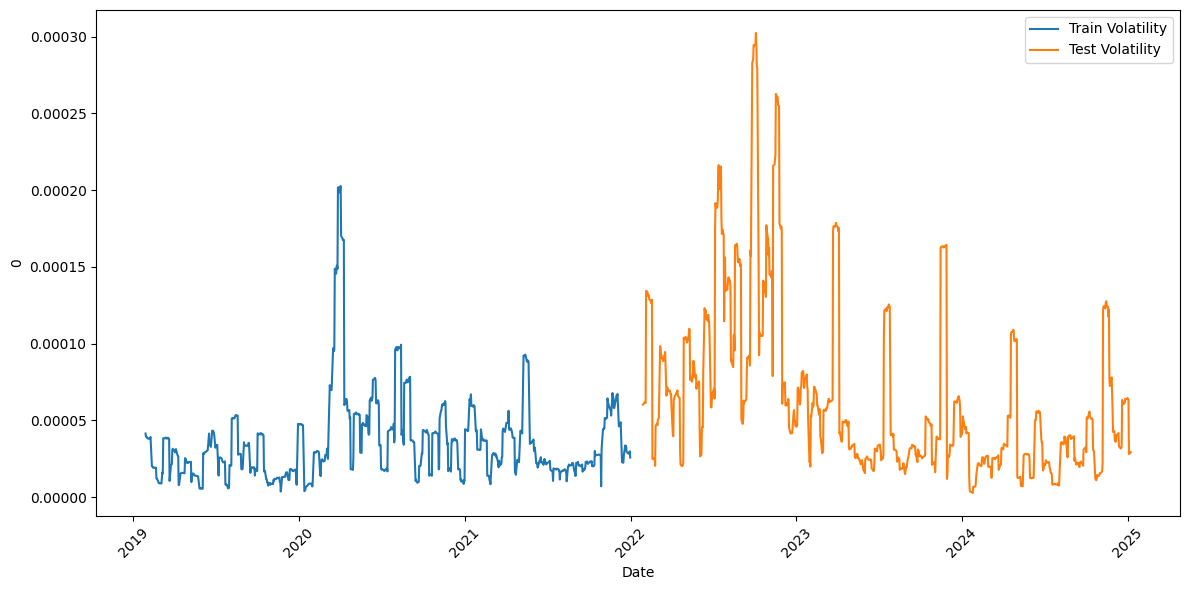

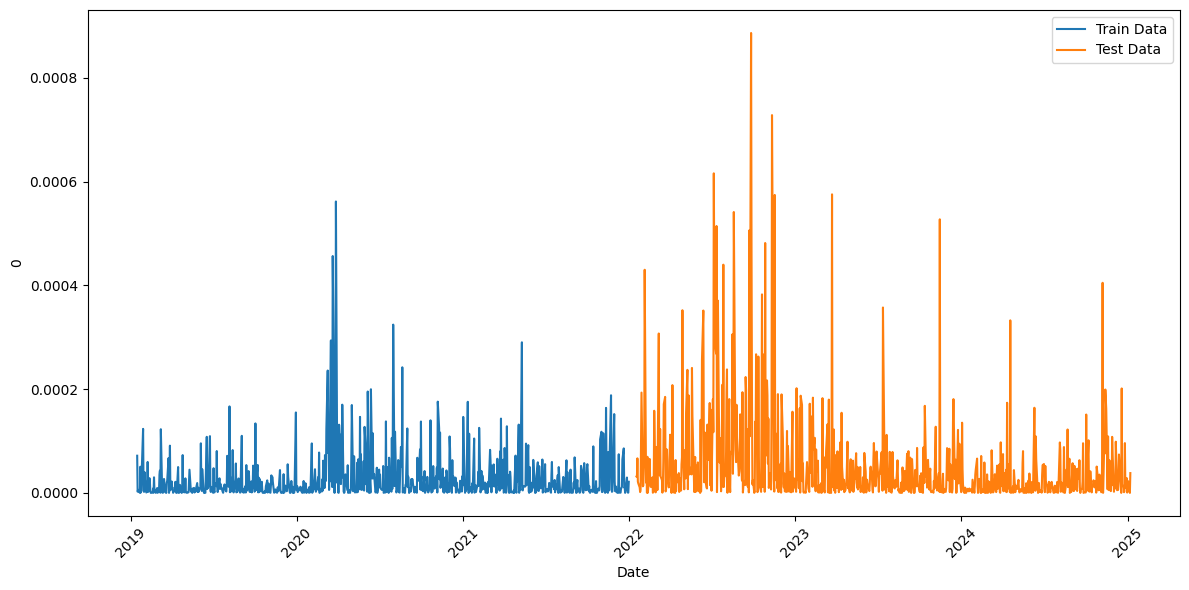

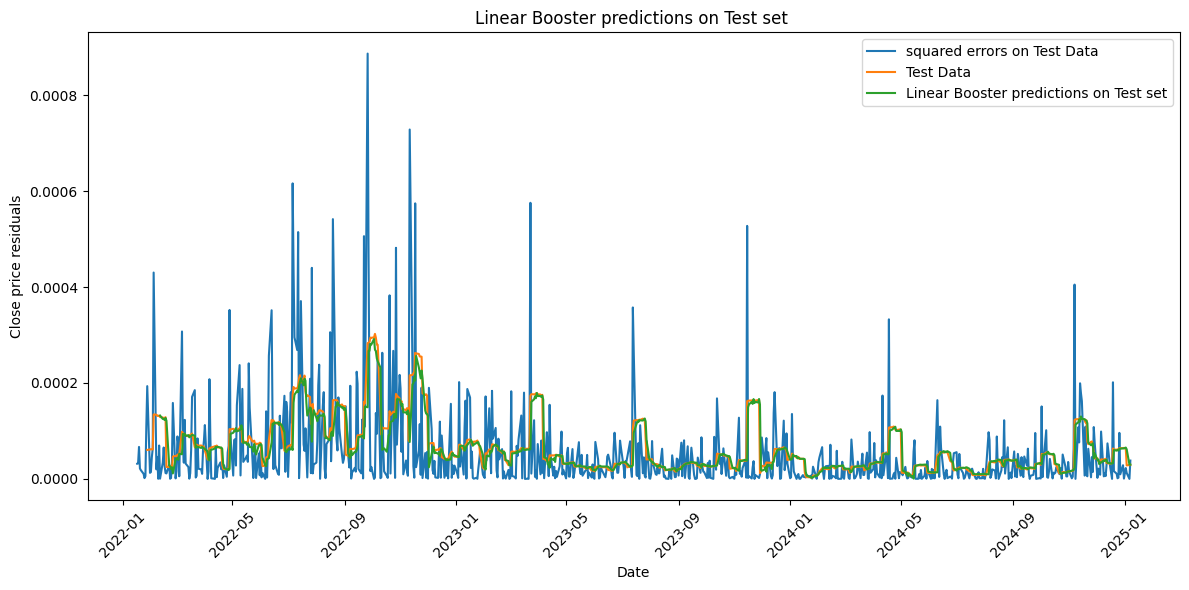

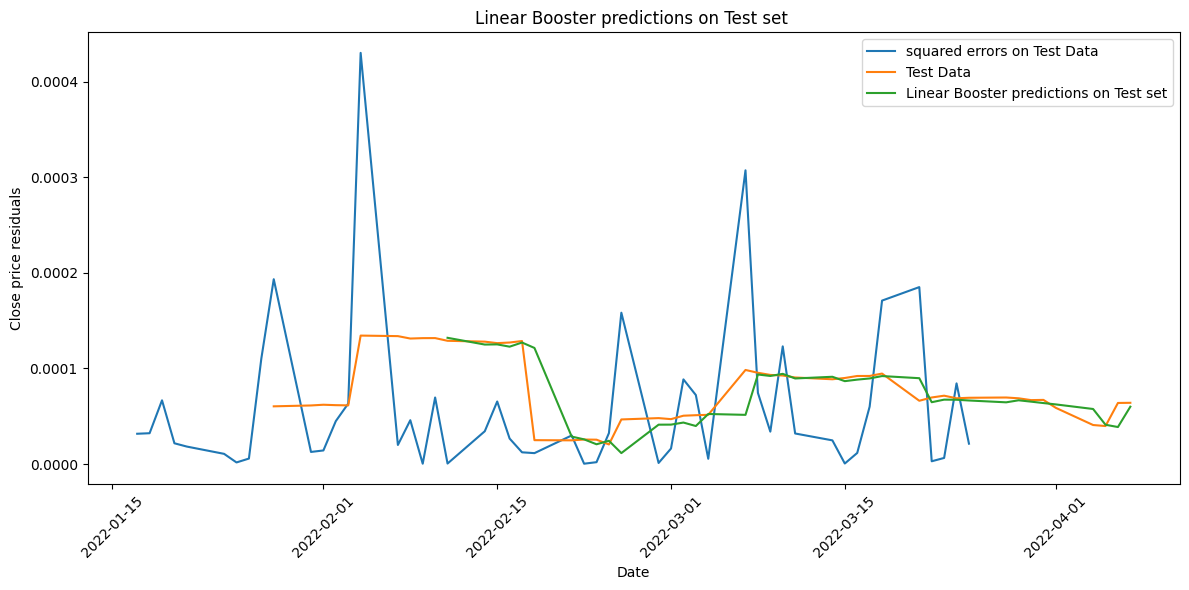

RMSE: 1.9658480798556988e-05
R2: 0.8779891729354858


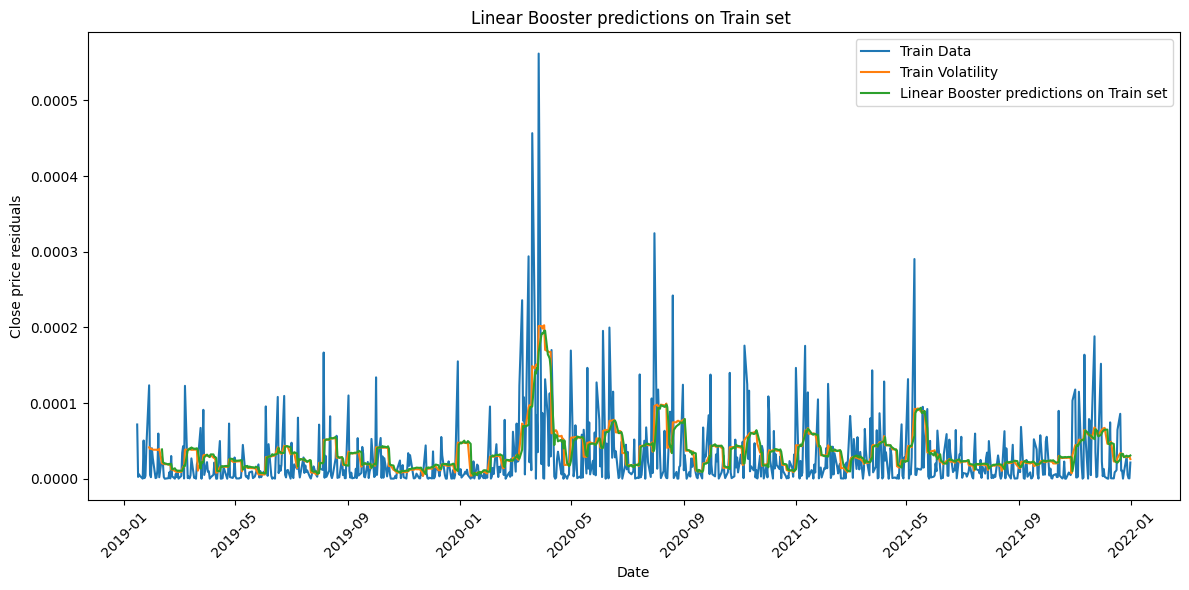

RMSE: 8.405740109502494e-06
R2: 0.9103479385375977


In [14]:
from scipy.stats import median_abs_deviation
def sliding_windows(data, seq_length):
    X, y = [], []

    for i in range(len(data) - seq_length ):
        _x = data.iloc[i:i+seq_length]
        _y = data.iloc[i + seq_length]
        X.append(_x)
        y.append(_y)

    return np.array(X), np.array(y)

train_errors = pd.read_csv("train_errori.csv", index_col=0)
test_errors = pd.read_csv("test_errori.csv", index_col=0)

train_errors.index = pd.to_datetime(train_errors.index)
test_errors.index = pd.to_datetime(test_errors.index)

train_volatility = train_errors.rolling(10).std()
test_volatility = test_errors.rolling(10).std()

train_volatility = train_volatility.dropna()
test_volatility = test_volatility.dropna()


#emwa volatility
# lambda_factor = 0.94  # Common value in finance
# squared_errors = np.random.randn(100) ** 2  # Replace with actual squared errors
# ewma_volatility = pd.Series(test_errors.iloc[:,0]).ewm(span=(2/(1-lambda_factor)-1)).mean() ** 0.5
# ewma_volatility.index = test_errors.index

# mad_volatility = pd.DataFrame(median_abs_deviation(test_errors) * 1.4826)
# mad_volatility.index = test_errors.index



#visualize
plt.figure(figsize=(12, 6))
sns.lineplot(x= train_volatility.index, y = train_volatility.squeeze(), label="Train Volatility")
sns.lineplot(x=test_volatility.index, y=test_volatility.squeeze(), label="Test Volatility")
plt.xticks(rotation=45)  # Rotate x-axis labels
plt.tight_layout() # Automatically adjusts the layout
plt.legend()
plt.show()


#original
plt.figure(figsize=(12, 6))
sns.lineplot(x= train_errors.index, y = train_errors.squeeze(), label="Train Data")
sns.lineplot(x=test_errors.index, y=test_errors.squeeze(), label="Test Data")
plt.xticks(rotation=45)  # Rotate x-axis labels
plt.tight_layout() # Automatically adjusts the layout
plt.legend()
plt.show()


#predict volatility
scaler = RobustScaler()
train_errors_scaled = pd.DataFrame(scaler.fit_transform(train_volatility), index = train_volatility.index)
test_errors_scaled = pd.DataFrame(scaler.transform(test_volatility), index = test_volatility.index)


X_train, y_train = sliding_windows(train_errors_scaled, 10)
X_test, y_test = sliding_windows(test_errors_scaled, 10)


# Flatten the sliding windows
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)


#train model
# best_params = {"n_estimators": 10,  "max_depth": 10,  "min_samples_split" : 10, "min_samples_leaf" : 0.002 }
best_params = {"n_estimators": 5,  "max_depth": 20,  "min_samples_split" : 2, "min_samples_leaf" : 0.002 }
ridge = Ridge(alpha=3)
model = LinearBoostRegressor(base_estimator=ridge, **best_params)
model.fit(X_train, y_train)


#predict
y_test_pred = model.predict(X_test)
y_train_pred = model.predict(X_train)


#inverse scale
y_test_pred = scaler.inverse_transform(y_test_pred.reshape(-1, 1))
y_train_pred = scaler.inverse_transform(y_train_pred.reshape(-1, 1))


#visualize
plt.figure(figsize=(12, 6))
sns.lineplot(x=test_errors.index, y=test_errors.squeeze(), label="squared errors on Test Data")
sns.lineplot(x= test_volatility.index, y = test_volatility.squeeze(), label="Test Data")
sns.lineplot(x=test_volatility[10:].index, y=y_test_pred.squeeze(), label="Linear Booster predictions on Test set")
# sns.lineplot(x=mad_volatility.index, y=mad_volatility.squeeze(), label="Linear Booster predictions on Train set")
plt.title(f'Linear Booster predictions on Test set ')
plt.xlabel('Date')
plt.ylabel('Close price residuals')
plt.xticks(rotation=45)  # Rotate x-axis labels
plt.tight_layout() # Automatically adjusts the layout
plt.legend()
plt.show()

#close up
plt.figure(figsize=(12, 6))
sns.lineplot(x=test_errors[:50].index, y=test_errors[:50].squeeze(), label="squared errors on Test Data")
sns.lineplot(x= test_volatility[:50].index, y = test_volatility[:50].squeeze(), label="Test Data")
sns.lineplot(x=test_volatility[10:50].index, y=y_test_pred[:40].squeeze(), label="Linear Booster predictions on Test set")
plt.title(f'Linear Booster predictions on Test set ')
plt.xlabel('Date')
plt.ylabel('Close price residuals')
plt.xticks(rotation=45)  # Rotate x-axis labels
plt.tight_layout() # Automatically adjusts the layout
plt.legend()
plt.show()


#compute metrics
rmse = np.sqrt(mean_squared_error(test_volatility[10:], y_test_pred))
r2 = r2_score(test_volatility[10:], y_test_pred)
print(f"RMSE: {rmse}")
print(f"R2: {r2}")



#fitted values
plt.figure(figsize=(12, 6))
sns.lineplot(x= train_errors.index, y = train_errors.squeeze(), label="Train Data")
sns.lineplot(x= train_volatility.index, y = train_volatility.squeeze(), label="Train Volatility")
sns.lineplot(x=train_errors[19:].index, y=y_train_pred.squeeze(), label="Linear Booster predictions on Train set")
plt.title(f'Linear Booster predictions on Train set ')
plt.xlabel('Date')
plt.ylabel('Close price residuals')
plt.xticks(rotation=45)  # Rotate x-axis labels
plt.tight_layout() # Automatically adjusts the layout
plt.legend()
plt.show()

#compute metrics
rmse = np.sqrt(mean_squared_error(train_volatility[10:], y_train_pred))
r2 = r2_score(train_volatility[10:], y_train_pred)
print(f"RMSE: {rmse}")
print(f"R2: {r2}")